# Initialize


In [1]:
expt_path = 'C:\\_Data\\Llotsa\\2025-05-14\\'
cfg_file='llotsa05_anneal.yml'
ip = '192.168.137.1'
max_t1 = 75

## Set up new config 
Set to variables to True when setting up a new experiment. 

Note: make sure you set your ADC/DAC channels correctly. This code does not automatically fill in the ADC/DAC into your configuration file, so you should check yourself to make sure these values are correct. 

There are several elements that you may want to customize based on your readout parameters and coherence times. Check readme file config_init_config_manual.md

In [2]:
# Set to false if you aren't creating a new one
new_config = False
new_folder = False

nqubits = 3
rfsoc_alias = 'bf1_soc'
t1_guess = 30 

import os
import slab_qick_calib.config as config

configs_dir = os.path.join(os.getcwd(), 'configs')
cfg_file_path = os.path.join(configs_dir, cfg_file)
images_dir = os.path.join(expt_path, 'images')
summary_dir = os.path.join(images_dir, 'summary')

if new_config or new_folder:


    if new_config:
        config.init_config(cfg_file_path, nqubits, type='full', aliases=rfsoc_alias, t1=t1_guess)

    if not os.path.exists(expt_path):
        os.makedirs(expt_path)
        os.mkdir(images_dir)
        os.mkdir(summary_dir)

print('Data will be stored in', expt_path)

Data will be stored in C:\_Data\Llotsa\2025-05-14\


## Connect to RFSoC
Before running first cell, make sure a nameserver is running on the network, the Qick board is connected to it, and the ip address listed below matches that of the nameserver. 

You just need to run the first cell, then should be able to run any other cell in whatever order. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qick import QickConfig
import sys 
sys.path.append('../')
from slab_qick_calib.exp_handling.instrumentmanager import InstrumentManager
import slab_qick_calib.experiments as meas
from slab_qick_calib.calib import qubit_tuning, tuneup
from slab_qick_calib import handy
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2

# Set color palette and font size
handy.config_figs()

# Results config file
cfg_path = os.path.join(os.getcwd(),'..', 'configs', cfg_file)
#cfg_path = os.path.join(configs_dir, cfg_file)
auto_cfg = config.load(cfg_path)

# Connect to instruments
im = InstrumentManager(ns_address=ip)
print(im)
soc = QickConfig(im[auto_cfg['aliases']['soc']].get_cfg())
print(soc)

cfg_dict = {'soc': soc, 'expt_path': expt_path, 'cfg_file': cfg_path, 'im': im}

imported experiments.single_qubit.active_reset
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.rabi
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.single_shot_opt
imported experiments.single_qubit.stark_spectroscopy
imported experiments.single_qubit.t1
imported experiments.single_qubit.t1_cont
imported experiments.single_qubit.t1_stark
imported experiments.single_qubit.t2
imported experiments.single_qubit.t2_ramsey_stark
imported experiments.single_qubit.tof_calibration
imported experiments.two_qubit.rabi_2q
imported experiments.two_qubit.t1_2q
imported experiments.two_qubit.t1_2q_cont
imported experiments.two_qubit.t1_2q_conttest
imported experiments.single_qubit.active_reset
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.rabi
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.sin

## How to update config (you can also just edit yml directly)

In [11]:
# #                                          param   value                        qubit #
# auto_cfg = config.update_readout(cfg_path, 'lamb', 5, qi)
# auto_cfg = config.update_qubit(cfg_path, 'f_ge', 5700, qi)

# # For multiple levels of nesting: 
# auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), 0.2, qi)


In general, all scans will be interacted with either by running default, or giving arguments from params dict. 
You can run scans on list of different qubits or just one by adding first couple lines of each cell. 
Flag of update is used to decide if to set new config vals based on output of scan (if the fit looks good)

## Check QICK issues

### Check mirror frequencies on qubit

In [ ]:
import qick_check

qick_check.check_freqs(0, cfg_dict)

### Check mirror frequencies from resonators

In [ ]:
qick_check.check_resonances(cfg_dict)

### Check sampling rates and minimum point spacing

In [ ]:
cfg_dict['soc']._get_ch_cfg(ro_ch=0)['f_dds']/2
cfg_dict['soc'].cycles2us(1)

### Make sure you're not near the nyquist frequency of the ADC

In [61]:
import qick_check
qick_check.check_adc(cfg_dict)

ADC sampling frequency: 2457.6
Distance to Nyquist zone 2 boundary: 62.7 MHz
This may cause readout issues. Consider adjusting the frequency.
Distance to Nyquist zone 2 boundary: 130.6 MHz
This may cause readout issues. Consider adjusting the frequency.


## Check potential sampling rates

In [95]:
soc.round_sample_rate(tiletype='dac', tile=0, fs_target=5000)

AttributeError: 'QickConfig' object has no attribute 'round_sample_rate'

# Time of Flight (TOF)

TOF measures the time it takes for the signal to run through the wires. It will give us the time in clock ticks that we should wait to make a measurements 

 Use this to set trig_offset in config file

In [ ]:
qubit_list = np.arange(3)
qubit_list = [0]
for qi in qubit_list:  
        tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi)

        # Set frequency of choice and readout length up to 13 us
        #tof=meas.ToFCalibrationExperiment(cfg_dict=cfg_dict, qi=qi,params={'readout_length':13})#,params={'frequency':fi})
       

## Set trig_offset to point where signal has appeared, usually around 500 ns


In [ ]:
qubit_list=np.arange(10)
for qi in qubit_list: 
    auto_cfg = config.update_readout(cfg_path, 'trig_offset', 0.65, qi)

# Resonator Spectroscopy 

Run resonator spectroscopy for all resonators by choosing a large frequency scan to look over. The scan will then find the different resonators and fill in the config file with their respective frequencies. In the autocalibration, there will be a finer sweep of each resonator to more accurately find its frequency. The frequencies are saved in <code>auto_cfg.device.readout.frequency</code>

## Coarse 

This will perform peak finding

  0%|          | 0/30600000 [00:00<?, ?it/s]

Number of peaks: 0


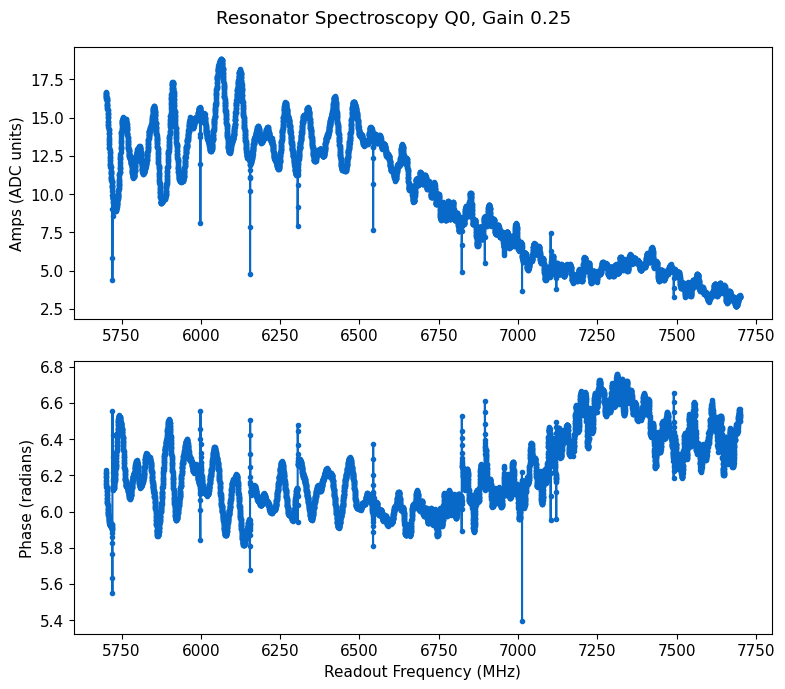

In [45]:
#rspec = cfg.make_rspec_coarse(soc, expt_path, cfg_path, i, im=im, start=6000, span=800, reps=2000, npts=5000)
qi=0
rspecc = meas.ResSpec(cfg_dict, qi=qi, style='coarse', params={'start':1100, 'span':2000, 'soft_avgs':1, 'reps':3000, 'gain':0.25, 'expts':10200})
res_values = rspecc.data['coarse_peaks']

Change prom (prominence value) to adjust how to find the peaks

Number of peaks: 11


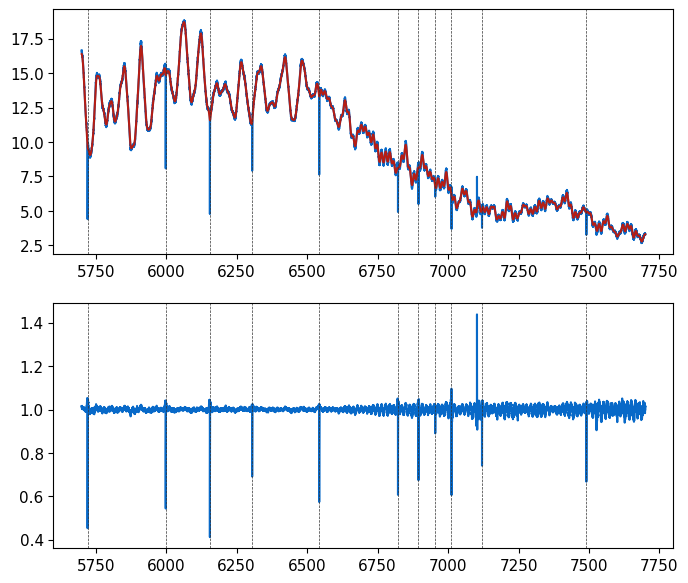

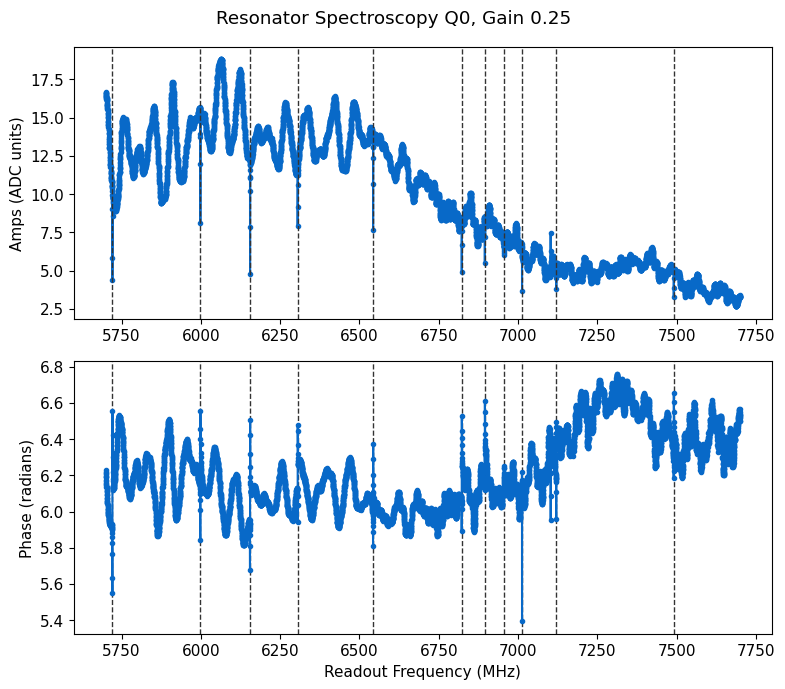

In [47]:
rspecc.analyze(peaks=True, debug=True, fit=False, prom=0.15)
rspecc.display(peaks=True, fit=False)
res_values = rspecc.data['coarse_peaks']

In [52]:
res_values

array([1121.17838802, 1398.45845661, 1555.13934402, 1705.15295963,
       1943.01768608, 2222.45481319, 2295.20651436, 2354.62367191,
       2520.52108212, 2890.75076351])

In [55]:
auto_cfg = config.load(cfg_path)
auto_cfg.device.readout.frequency[0:10]

[1121.0198,
 1398.1182,
 1554.9633,
 1705.0595,
 1942.9772,
 2222.2407,
 2294.9041,
 2520.187,
 2890.6054,
 2942.3607]

Can delete values from res_values if they don't seem to be real res_values. 

In [50]:
res_values = np.delete(res_values, 8)

## Fine

This will fit the resonance amplitude

  0%|          | 0/133540 [00:00<?, ?it/s]

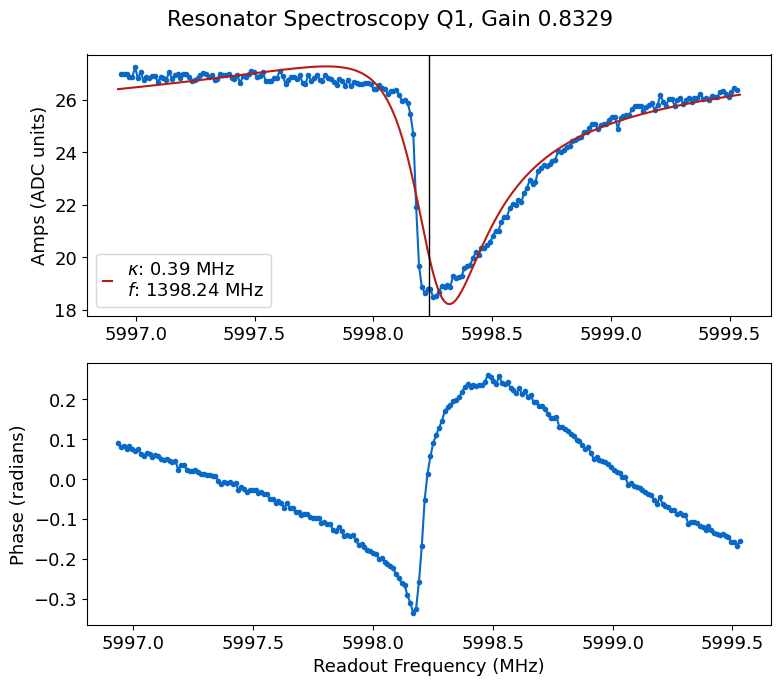

*Set cfg device.readout 1 frequency to 1398.252 from 1398.235*
*Set cfg device.readout 1 kappa to 0.3922 from 0.3743*
*Set cfg device.readout 1 qi to 2.3656 from 2.4613*
*Set cfg device.readout 1 qe to 4.3264 from 4.5919*


In [48]:
# Just run one  
update=True

qubit_list = np.arange(10)
qubit_list=[1]

for qi in qubit_list:    
    # Used for initial finding of resonance 
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'center':res_values[qi]})

    # Manually set the span and gain 
    #rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':5, 'gain':0.03})

    # Fully automated, using previous fit to kappa tp set s[am]
    rspec = meas.ResSpec(cfg_dict, qi=qi, params={'span':'kappa'})
    if update: rspec.update(cfg_dict['cfg_file'])

#plot will appear weird first because it plots the resonator frequency in the config on the same plot

## Resonator Power Spectroscopy 

Find a good value for gain to park your readout at until you run readout optimization. From the 2D sweep that is produced, choose a value for gain that is right before the resonator 'breaks' (goes from e -> f). Want to choose a high value for gain because we want to be in the shot noise limited regime which increases our signal:noise ratio. The gain value should be saved in <code>auto_cfg.device.readout.gain</code>

[0, 0, 0, 0, 1, 1, 1, 2, 2, 4, 5, 8, 12, 17, 26, 38, 56, 83, 123, 183, 271, 401, 595, 881, 1306, 1936, 2869, 4252, 6301, 9338]


  0%|          | 0/30 [00:00<?, ?it/s]

High power peak [MHz]: 1390.4722051329104
Low power peak [MHz]: 1391.3409778607243
Lamb shift [MHz]: -0.8687727278138482


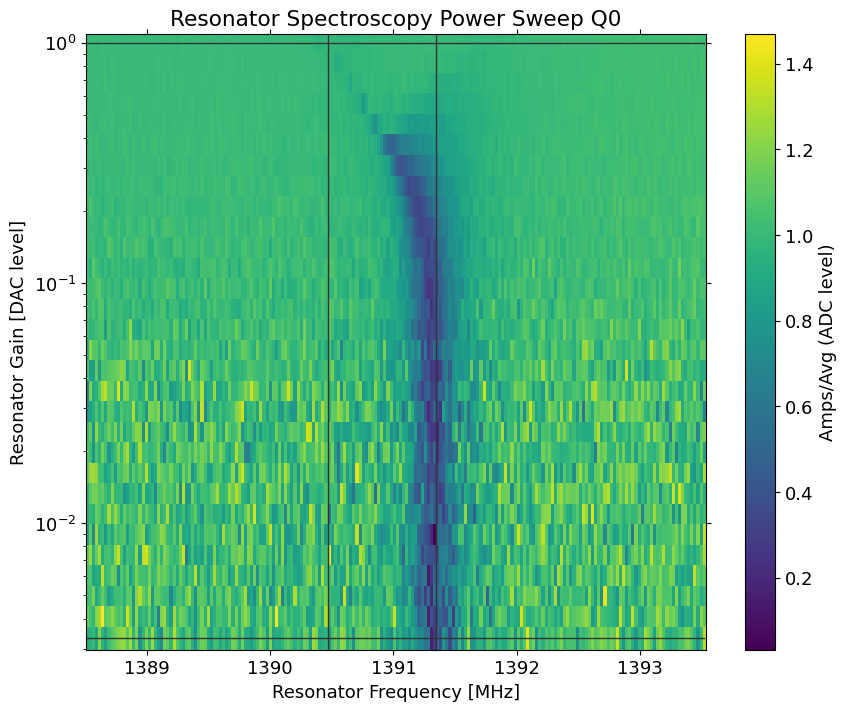

*Set cfg device.readout 0 lamb to -0.8688 from 0*


In [13]:
update=True

qubit_list = np.arange(13,20)
qubit_list=[0]

d=[]
for qi in qubit_list:
    #rpowspec=meas.ResSpecPower(cfg_dict, qi=qi)
    rpowspec=meas.ResSpecPower(cfg_dict, qi=qi, params={'rng':300,'max_gain':1, 'span':5,"f_off":1,'expts_gain':30})
    d.append(rpowspec)
    if update:
        auto_cfg = config.update_readout(cfg_path, 'lamb', rpowspec.data['lamb_shift'], qi)


In [ ]:
rpowspec.print()

In [ ]:
auto_cfg = config.load(cfg_path)
horz_line = auto_cfg.device.readout.gain
handy.plot_many(d, title='Resonator Power', save_path=cfg_dict['expt_path'], chan='amps', yax='log', norm=True, horz_line=horz_line)

### Save gain values 

In [ ]:
# assign the resonator gain to the results config file
gain_values = [0.1,0.01]
for i in range(num_qubits):
    auto_cfg = config.update_readout(cfg_file, 'gain', int(gain_values[i]), i)

# Qubit Spectroscopy

## Find qubits

More automated, best to use once you're confident of qubit location and just refinding it 

Performing medium scan


  0%|          | 0/49800 [00:00<?, ?it/s]

R2:0.797	Fit par error:0.032	 Best fit:b'avgi'


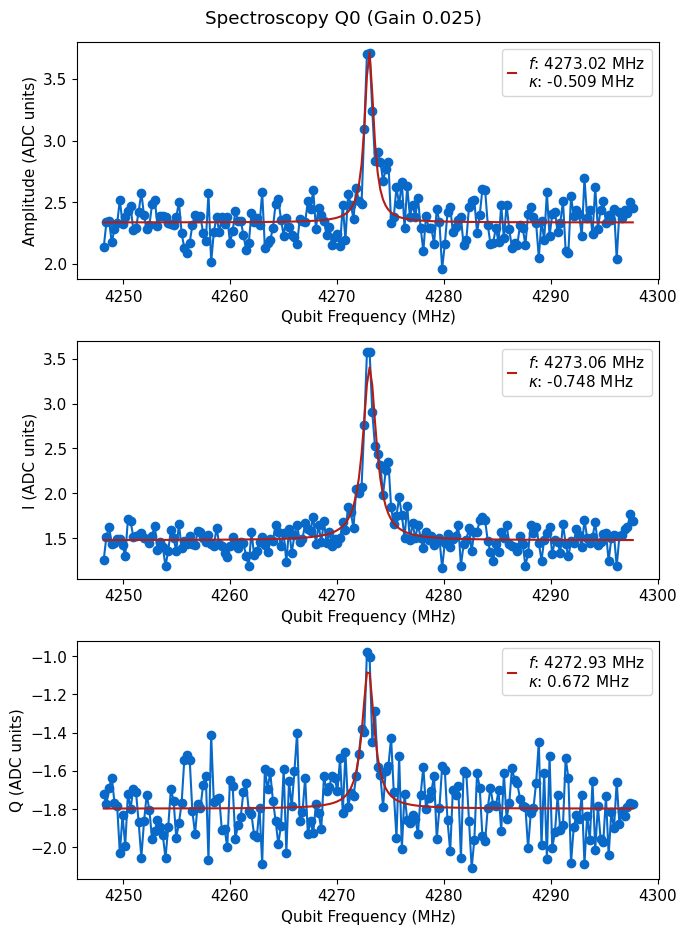

*Set cfg device.qubit 0 f_ge to 4273.0559 from 4272.9353*
Performing fine scan


  0%|          | 0/49800 [00:00<?, ?it/s]

R2:0.840	Fit par error:0.039	 Best fit:b'avgi'


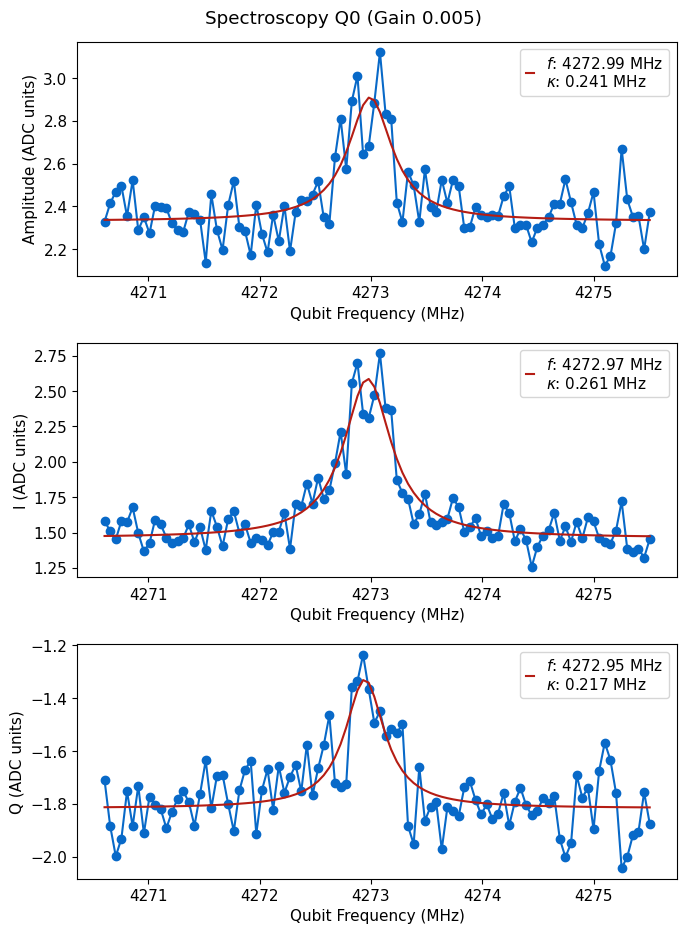

*Set cfg device.qubit 0 f_ge to 4272.9703 from 4273.0559*
Found qubit 0


In [88]:
qubit_list = np.arange(10)
qubit_list= [0]

bad_qubits=[]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium')
    if not status:
        bad_qubits.append(qi)

## General search, specify width 

fine, medium, coarse, huge (will change scan width and power)

Uses config values of low_gain (gain to use for finest scan), which sets overall gain for device and spec_gain (set indepedently for each qubit) to decide how much power to apply

  0%|          | 0/51200 [00:00<?, ?it/s]

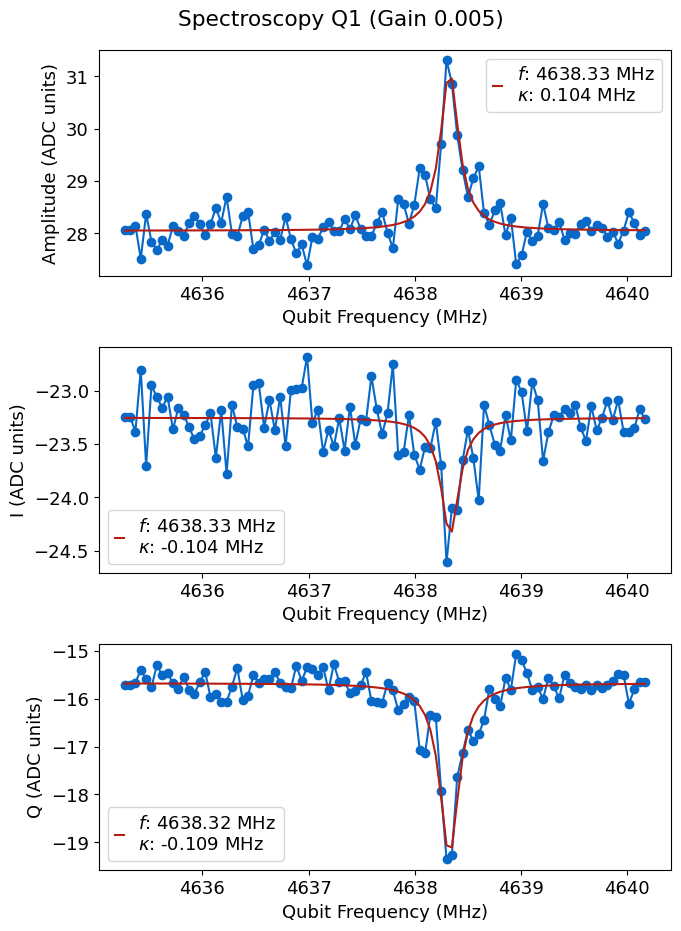

In [10]:
update=False

#qubit_list = np.arange(5)
qubit_list = [1]

for qi in qubit_list: 
    # Default, just specifiy style 
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='fine')

    # Different examples of params you might give; frequency can be specified as start and span or if no start given, center is f_ge from config
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'span':80,'expts':100,'gain':0.01,'reps':30000, 'length':1.5})
    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params={'start':3100,'span':200,'expts':1000,'gain':1,'reps':800})
    if update and qspec.status: 
        auto_cfg = config.update_qubit(cfg_path, 'f_ge', qspec.data["best_fit"][2], qi)
        auto_cfg = config.update_qubit(cfg_path, 'kappa',2*qspec.data["best_fit"][3], qi)
    elif update:
        print(f'Bad qubit! qi={qi}')

## Stark (not tested yet)

Unexpected parameters found in params: {'stark_freq'}


  0%|          | 0/2428000 [00:00<?, ?it/s]

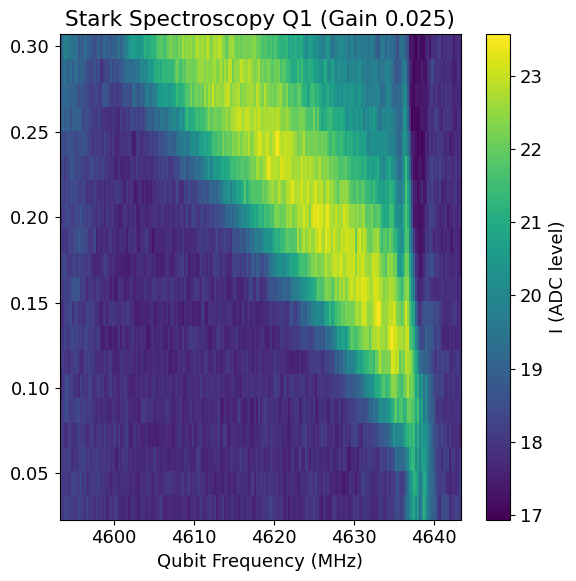

In [41]:
qi=1
qspec=meas.StarkSpec(cfg_dict, qi=qi, style='medium', params={'df_stark':0.5, 'max_stark_gain':0.3, 'df':-20})

In [62]:
Delta = auto_cfg.device.readout.frequency[qi]-auto_cfg.device.qubit.f_ge[qi]+4600

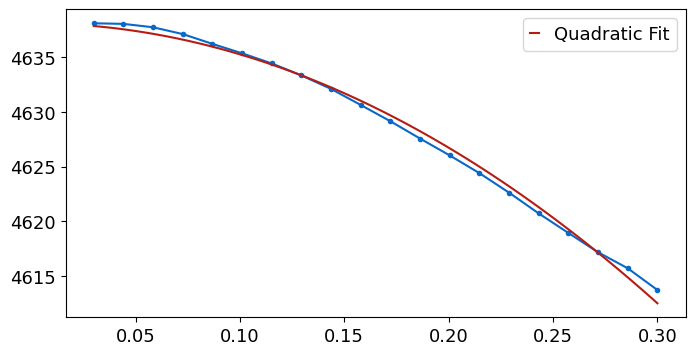

In [60]:
from scipy.optimize import curve_fit

f = [qspec.data['fit_avgi'][i][2] for i in range(len(qspec.data['fit_avgi']))]

plt.figure()
plt.plot(qspec.data['stark_gain'],f,'.-')
# Define a quadratic function
def quadratic(x, a, c):
    return a * x**2  + c

# Fit the data
popt, pcov = curve_fit(quadratic, qspec.data['stark_gain'], f)

# Plot the fitted curve
x_fit = np.linspace(min(qspec.data['stark_gain']), max(qspec.data['stark_gain']), 100)
y_fit = quadratic(x_fit, *popt)
plt.plot(x_fit, y_fit, label='Quadratic Fit')
plt.legend()

In [63]:
popt[0]*Delta/120**2/2

-13.439733615631686

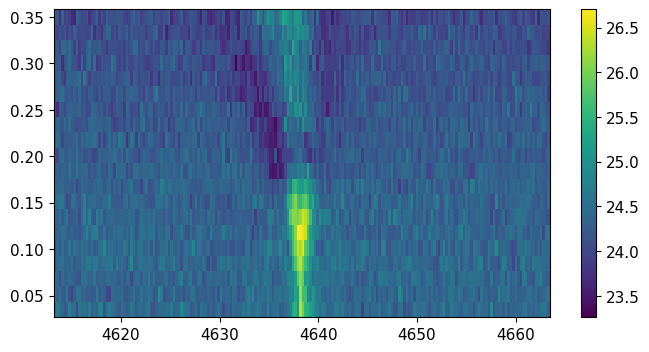

In [85]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()

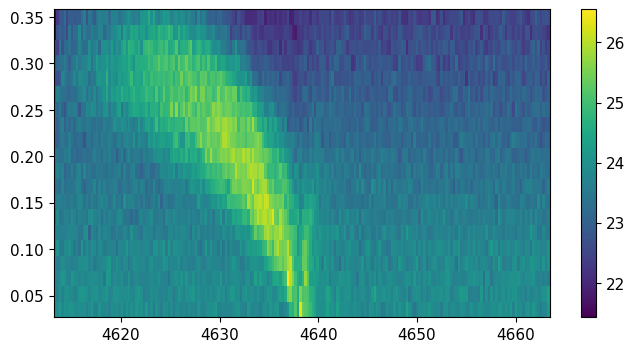

In [83]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()

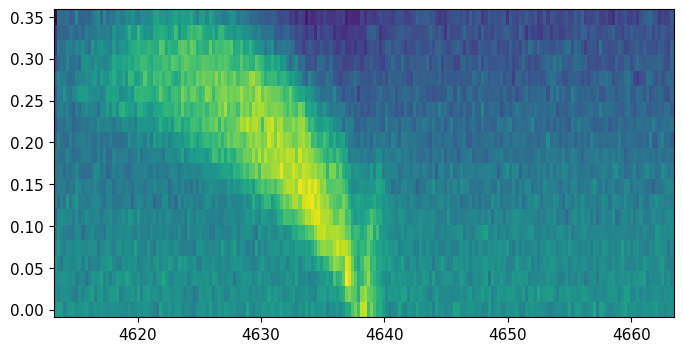

In [ ]:
plt.figure()
plt.pcolormesh(qspec.data['xpts'], qspec.data['stark_gain'], qspec.data['amps'])
plt.colorbar()


In [77]:
qspec.data.keys()

dict_keys(['xpts', 'avgi', 'avgq', 'amps', 'phases', 'start_time', 'stark_gain'])

## Power sweep

### Multiple wide scans looking for qubit

In [ ]:
qubit_list = np.arange(20)
qubit_list=[1]

span = 250
start_all = [2000, 3100, 3400]
end_all = [4780, 3700, 4250]
sensitivities = [0.8, 0.4, 0.2]

d = []
for qi in tqdm(qubit_list, desc='Qubit Number'):
    starts = np.arange(start_all[qi], end_all[qi], span)
    qresults = []
    for start in tqdm(starts, desc=f'Start Frequency Sweep'):
        q_res = meas.QubitSpecPower(
            cfg_dict, 
            qi=qi, 
            style='coarse', 
            params={
                'max_gain':0.8,
                'start':start,
                'span':span,
                'rng':100,
                'reps':800}
        )#,'start':3000,'span':300'})
        qresults.append(q_res)
    
    # Handy plot
    handy.plot_many_limited(
        qresults, 
        title=f'Qubit Power for qubit {qi}', 
        save_path=cfg_dict['expt_path'],
        yax='log', 
        chan='amps', 
        individial_fig_size= (6,6), 
        xlabel='Frequency (MHz)',
        sensitivity =  sensitivities[qi],
        save = False,
    )
    d.append(q_res)
    plt.show()

In [ ]:
qubit_list=[2]

for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200})
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='', params={'start':3700,'span':600,'reps':1500,'expts':1200, 'max_gain':0.4, 'length':1,'sep_readout':True})

### Narrow scan

Unexpected parameters found in params: {'log', 'max_gain', 'expts_gain', 'rng'}
Unexpected parameters found in params: {'sep_readout', 'active_reset', 'final_delay', 'readout_length', 'qubit', 'length', 'soft_avgs', 'qubit_chan', 'start', 'gain', 'checkEF', 'pulse_type'}


  0%|          | 0/10 [00:00<?, ?it/s]

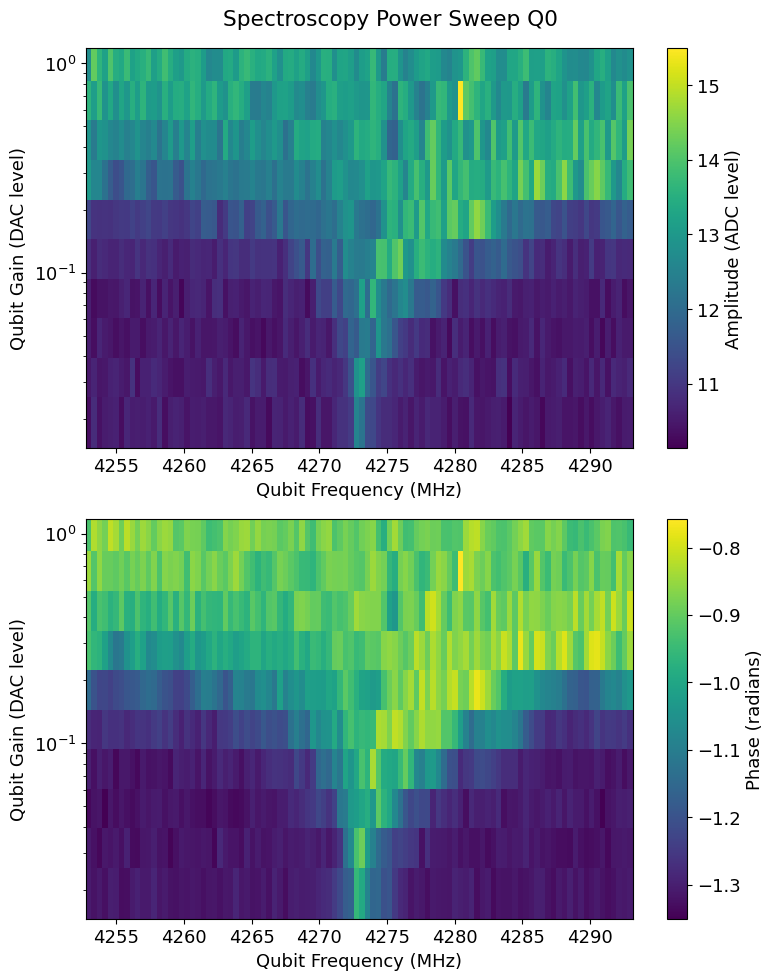

In [12]:
qq=[]

# qubit_list = np.arange(20)
qubit_list=[0]
for qi in qubit_list:
    qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine')
    
    # Nice for pretty pics once you have T1 measurement. 
    #qspec_pow = meas.QubitSpecPower(cfg_dict, qi=qi, style='fine', params={'length':'t1','max_gain':1})
    qq.append(qspec_pow)

# When measuring many qubits, can do a bunch of color plots this way
#handy.plot_many(qq, title='Qubit Power Amps 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='amps')
#handy.plot_many(qq, title='Qubit Power Phase 0.6-0.2', save_path=cfg_dict['expt_path'], yax='log', chan='phases')

# Coherent scans

## Fast tuneup

Options are: 

first_time: assume we don't know t1 time,don't have single shot working

single: do single shot readout optimization 

readout: set readout frequency based on resonator fit

  0%|          | 0/133540 [00:00<?, ?it/s]

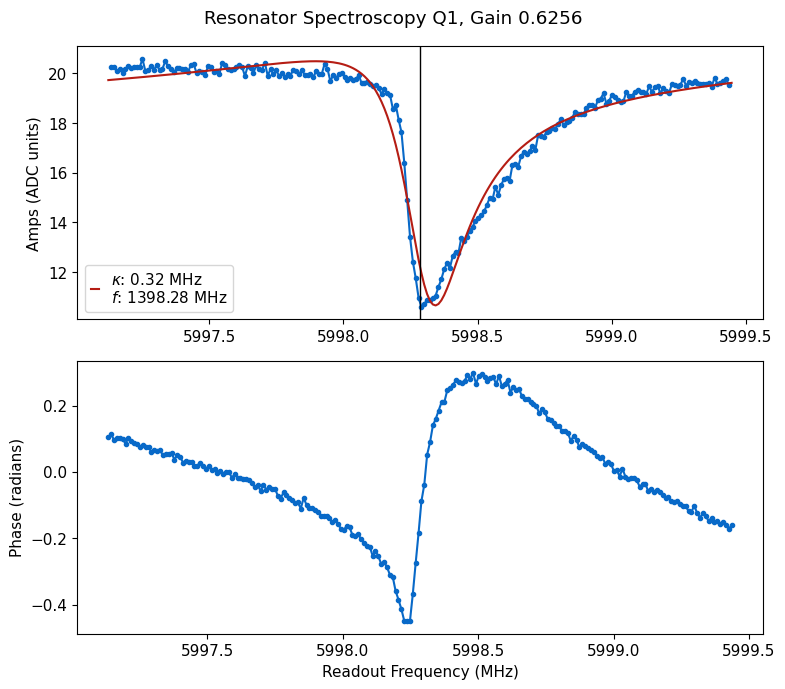

*Set cfg device.readout 1 frequency to 1398.2908 from 1398.2865*
*Set cfg device.readout 1 kappa to 0.3197 from 0.332*
*Set cfg device.readout 1 qi to 3.8256 from 3.0173*
*Set cfg device.readout 1 qe to 3.6818 from 4.0376*


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

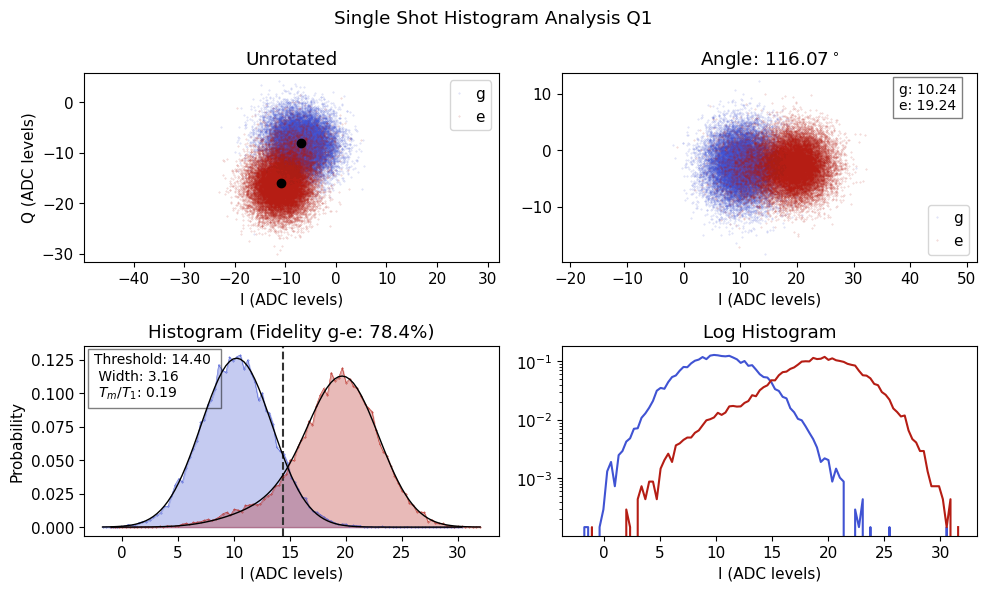

*Set cfg device.readout 1 phase to 116.0716 from -177.7114*
*Set cfg device.readout 1 threshold to 14.403 from 14.2568*
*Set cfg device.readout 1 fidelity to 0.784 from 0.7564*
*Set cfg device.readout 1 sigma to 3.1617 from 3.2187*
*Set cfg device.readout 1 tm to 0.1946 from 0.1773*
*Set cfg device.qubit 1 tuned_up to True from True*


  0%|          | 0/2 [00:00<?, ?it/s]

R2:0.994	Fit par error:0.008	 Best fit:b'avgi'


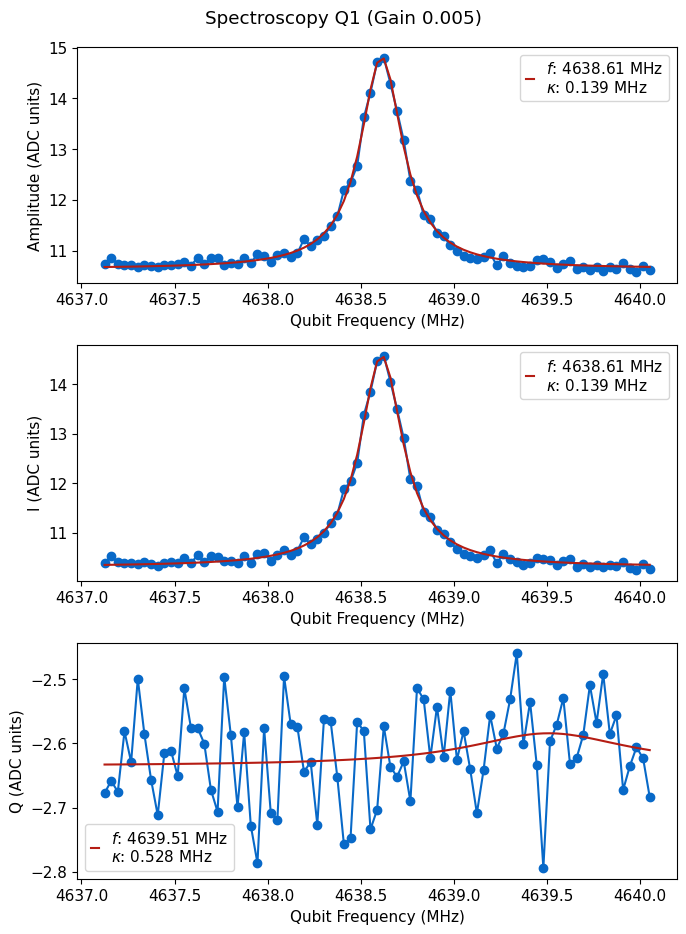

  0%|          | 0/36420 [00:00<?, ?it/s]

R2:0.996	Fit par error:0.006	 Best fit:b'avgi'


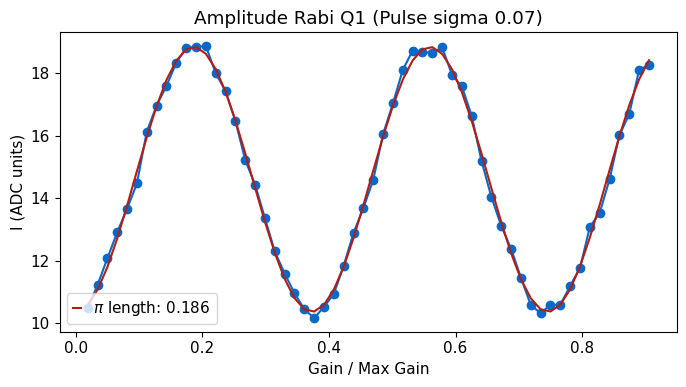

*Set cfg device.qubit 1 ('pulses', 'pi_ge', 'gain') to 0.186 from 0.1843*
Try 0


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.962	Fit par error:0.022	 Best fit:b'avgi'


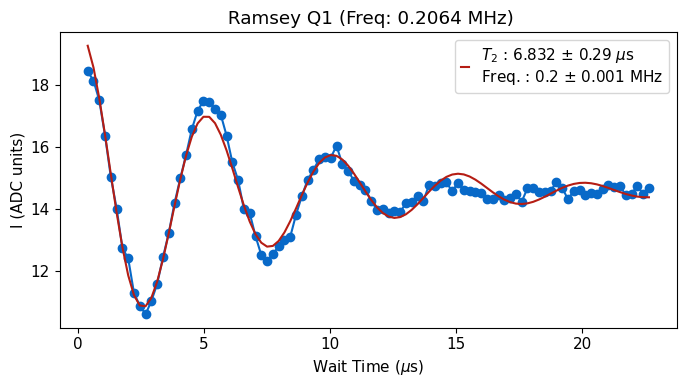

Scan successful. New frequency error is 0.006 MHz
*Set cfg device.qubit 1 f_ge to 4638.5946 from 4638.5882*
*Set cfg device.qubit 1 T2r to 6.8317 from 7.61*
Total Change in frequency: 0.006 MHz
[0.006369386390258414]
Qubit 1 recentered from 4638.5882 to 4638.5946


  0%|          | 0/36420 [00:00<?, ?it/s]

R2:0.996	Fit par error:0.006	 Best fit:b'avgi'


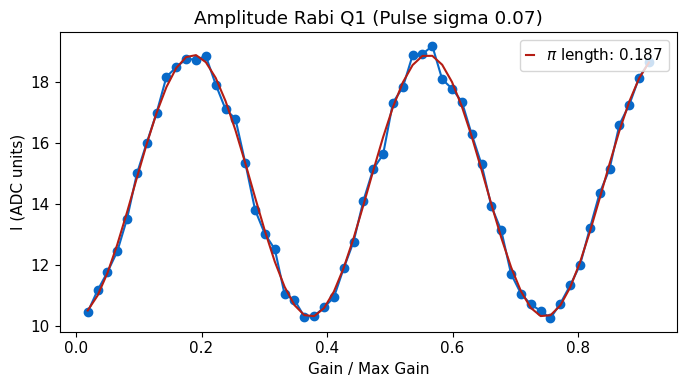

*Set cfg device.qubit 1 ('pulses', 'pi_ge', 'gain') to 0.1867 from 0.186*
Unexpected parameters found in params: {'step_f', 'step_len', 'step_gain'}


  0%|          | 0/7 [00:00<?, ?it/s]

Max fidelity 79.799 %
Optimal params: 
 Freq (MHz) 1398.291 
 Gain (DAC units) 0.751 
 Readout length (us) 5.225
Set fidelity: 76.779 %
Set params: 
 Freq (MHz) 1398.291 
 Gain (DAC units) 0.542 
 Readout length (us) 4.354


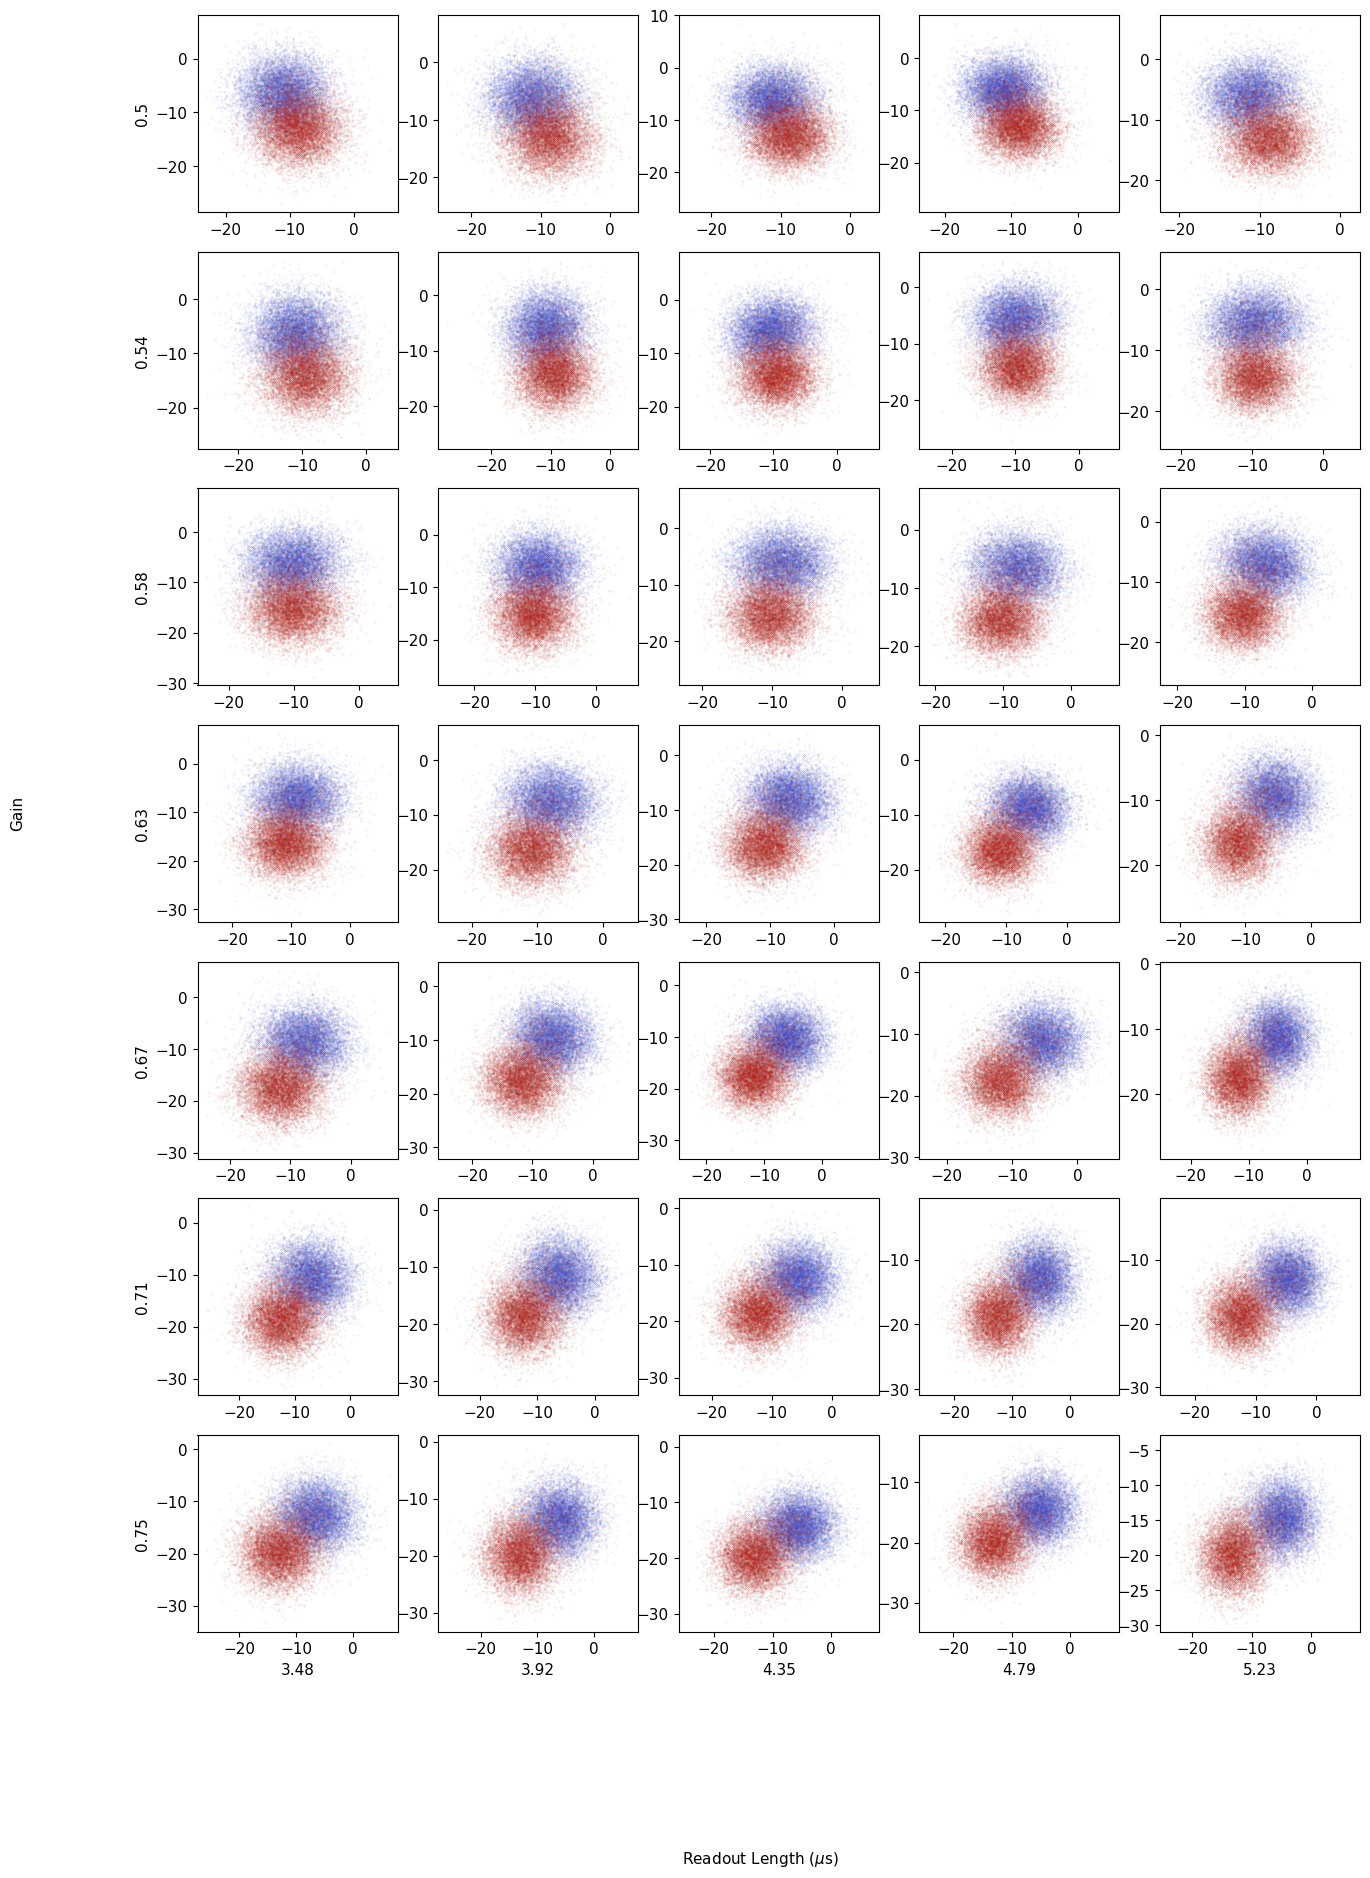

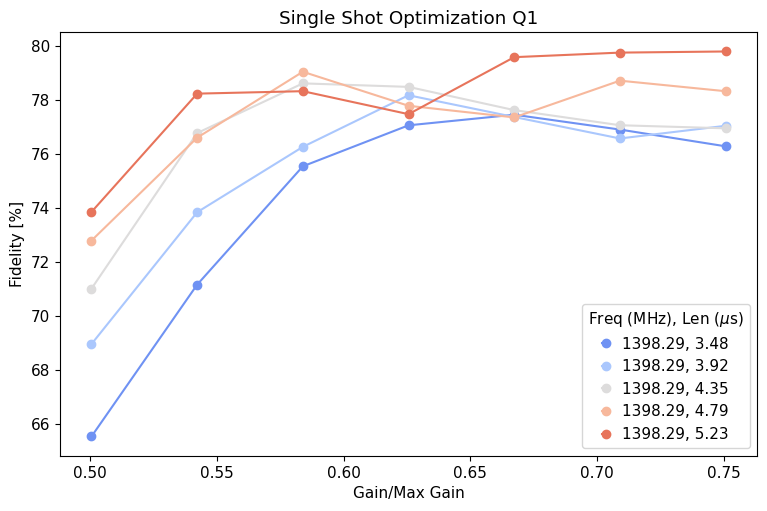

*Set cfg device.readout 1 gain to 0.5422 from 0.6256*
*Set cfg device.readout 1 readout_length to 4.3542 from 4.3542*


  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

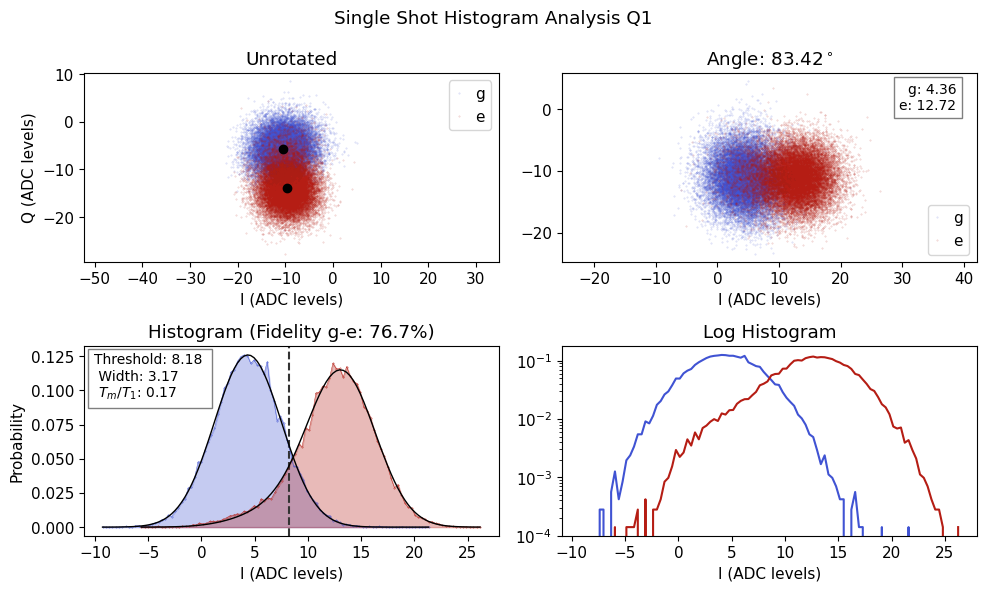

*Set cfg device.readout 1 phase to 83.4188 from 116.0716*
*Set cfg device.readout 1 threshold to 8.1811 from 14.403*
*Set cfg device.readout 1 fidelity to 0.7673 from 0.784*
*Set cfg device.readout 1 sigma to 3.1663 from 3.1617*
*Set cfg device.readout 1 tm to 0.1677 from 0.1946*
*Set cfg device.qubit 1 tuned_up to True from True*


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.985	Fit par error:0.015	 Best fit:b'avgi'


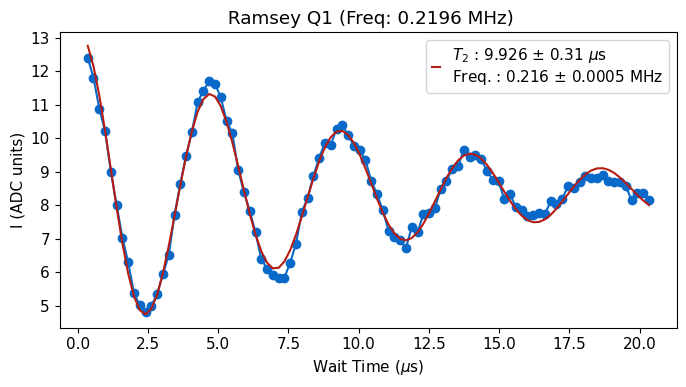

*Set cfg device.qubit 1 T2r to 9.93 from 6.8317*


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.956	Fit par error:0.026	 Best fit:b'avgi'


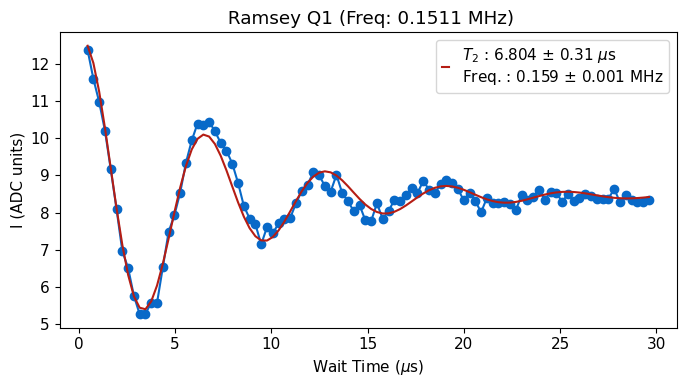

*Set cfg device.qubit 1 T2r to 6.8 from 9.93*


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.984	Fit par error:0.015	 Best fit:b'avgi'


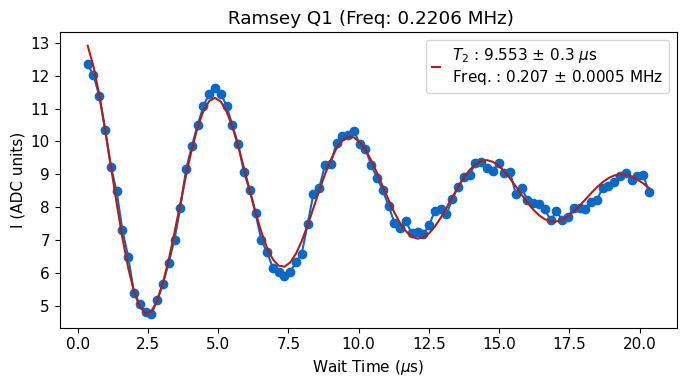

*Set cfg device.qubit 1 T2r to 9.55 from 6.8*


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.969	Fit par error:0.020	 Best fit:b'avgi'


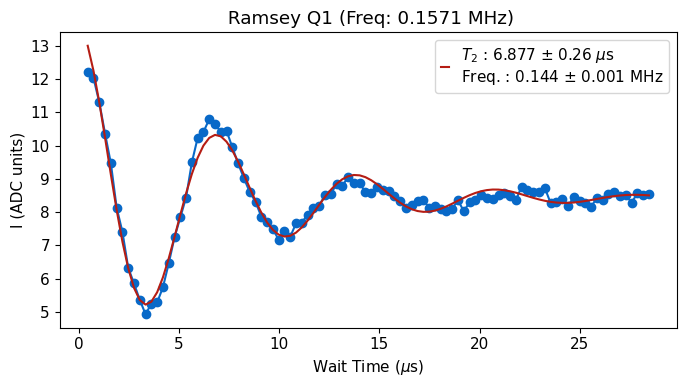

*Set cfg device.qubit 1 T2r to 6.88 from 9.55*


  0%|          | 0/72840 [00:00<?, ?it/s]

R2:0.995	Fit par error:0.017	 Best fit:b'avgi'


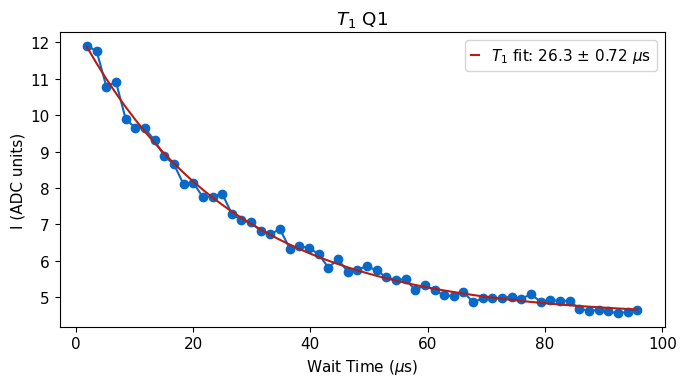

*Set cfg device.qubit 1 T1 to 26.28 from 26.24*
*Set cfg device.readout 1 final_delay to 157.7 from 157.42*


  0%|          | 0/121400 [00:00<?, ?it/s]

R2:0.983	Fit par error:0.012	 Best fit:b'avgi'


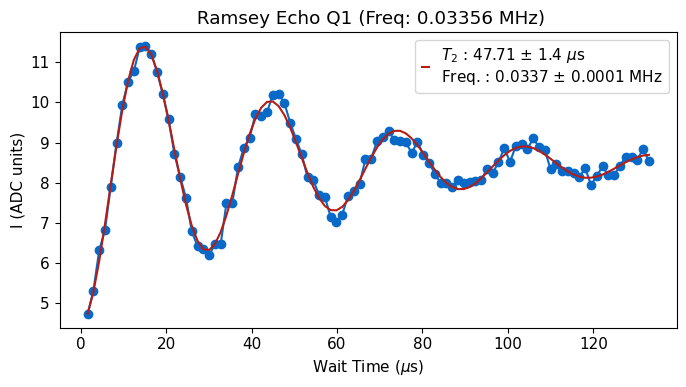

*Set cfg device.qubit 1 T2e to 47.71 from 44.7*


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

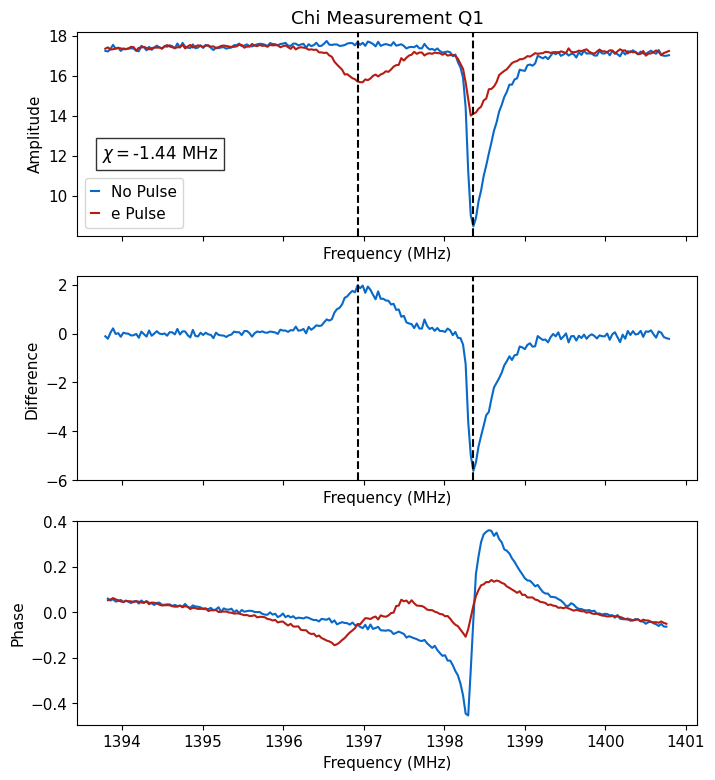

*Set cfg device.readout 1 chi to -1.438 from -1.4699*


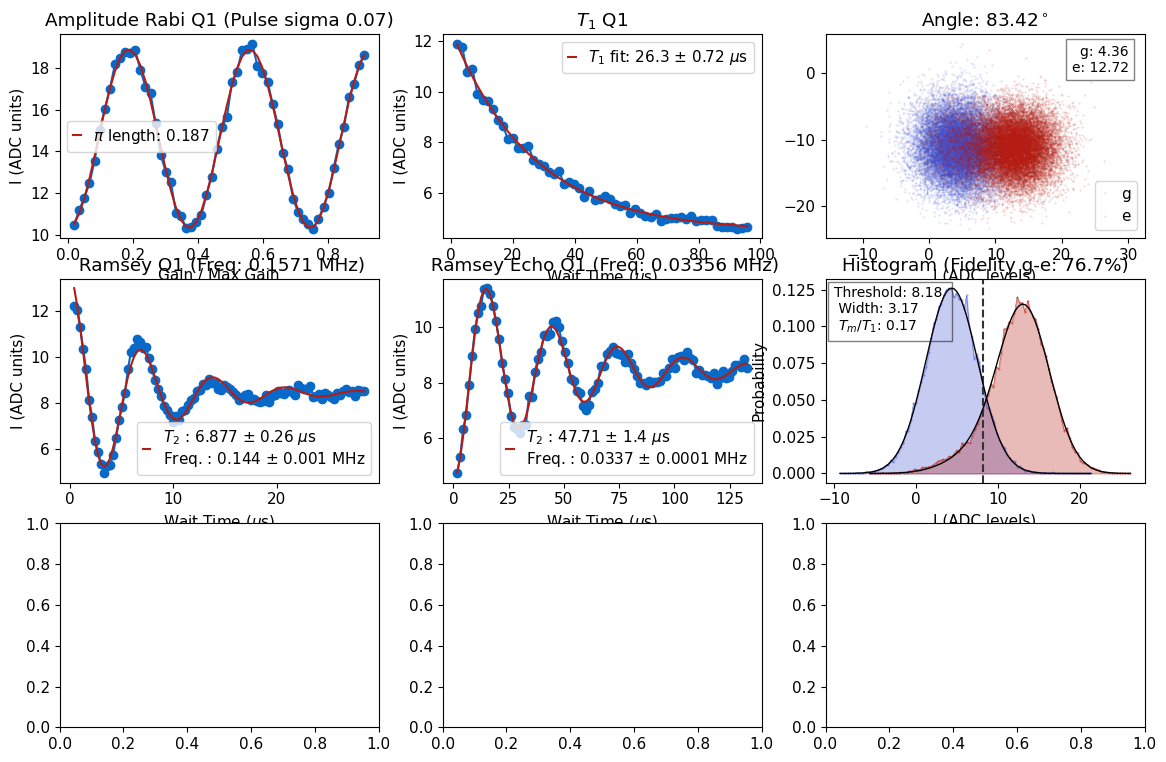

C:\_Data\Llotsa\Tracking\2025_05_21_19_35_48.0hrsimages\summary\qubit1_tuneup_20250522_1415.png


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\_Data\\Llotsa\\Tracking\\2025_05_21_19_35_48.0hrsimages\\summary\\qubit1_tuneup_20250522_1415.png'

In [83]:
qubit_list = np.arange(10)
qubit_list=[1]

#qubit_list=np.delete(qubit_list, [5,13])
# Worst issue with this right now is when the qubit frequency is not correct and readout is bad; gets stuck doing ramsey/spectroscopy forever. In this case, cancel it and go back to find qubits, try changing readout gain. 
plt.rcParams.update({'font.size': 11})
for qi in qubit_list: 
    qubit_tuning.tune_up_qubit(qi, cfg_dict, first_time=False, single=True, readout=True)

## Time tracking

In [82]:
scan_length = 48
cfg_dict['expt_path']=expt_path
qubit_list = np.arange(20)
bad_qubits = [0,5,13]
qubit_list = np.delete(qubit_list, bad_qubits)

qubit_list = [1]

tt=qubit_tuning.time_tracking(qubit_list, cfg_dict,display=False,total_time=scan_length, fast=True)
cfg_dict['expt_path']=expt_path

Starting run 0, for qubit 1. Time elapsed 0.00 hrs
R2:0.967	Fit par error:0.030	 Best fit:b'avgi'
R2:0.995	Fit par error:0.022	 Best fit:b'avgi'
R2:0.987	Fit par error:0.018	 Best fit:b'avgi'
Starting run 1, for qubit 1. Time elapsed 0.01 hrs
R2:0.971	Fit par error:0.029	 Best fit:b'avgi'
R2:0.995	Fit par error:0.020	 Best fit:b'avgi'
R2:0.987	Fit par error:0.018	 Best fit:b'avgi'
Starting run 2, for qubit 1. Time elapsed 0.02 hrs
R2:0.962	Fit par error:0.035	 Best fit:b'avgi'
R2:0.995	Fit par error:0.022	 Best fit:b'avgi'
R2:0.985	Fit par error:0.019	 Best fit:b'avgi'
Starting run 3, for qubit 1. Time elapsed 0.03 hrs
R2:0.985	Fit par error:0.021	 Best fit:b'avgi'
R2:0.998	Fit par error:0.013	 Best fit:b'avgi'
R2:0.983	Fit par error:0.021	 Best fit:b'avgi'
Starting run 4, for qubit 1. Time elapsed 0.04 hrs
R2:0.947	Fit par error:0.037	 Best fit:b'avgi'
R2:0.996	Fit par error:0.017	 Best fit:b'avgi'
R2:0.982	Fit par error:0.021	 Best fit:b'avgi'
Starting run 5, for qubit 1. Time elapse

C:\_Lib\python\slab_qick_calib\fitting.py:593: RuntimeWarning: overflow encountered in exp
  return yscale * (np.sin(2 * np.pi * freq * x + phase_deg * np.pi / 180) + slope) * np.exp(-x / decay) + y0


R2:0.983	Fit par error:0.021	 Best fit:b'avgi'
Starting run 6, for qubit 1. Time elapsed 0.06 hrs
R2:0.983	Fit par error:0.021	 Best fit:b'avgi'
R2:0.997	Fit par error:0.016	 Best fit:b'avgi'
R2:0.983	Fit par error:0.021	 Best fit:b'avgi'
Starting run 7, for qubit 1. Time elapsed 0.06 hrs
R2:0.950	Fit par error:0.038	 Best fit:b'avgi'
R2:0.995	Fit par error:0.020	 Best fit:b'avgi'
R2:0.967	Fit par error:0.025	 Best fit:b'avgi'
Starting run 8, for qubit 1. Time elapsed 0.07 hrs
R2:0.971	Fit par error:0.028	 Best fit:b'avgi'
R2:0.997	Fit par error:0.016	 Best fit:b'avgi'
R2:0.991	Fit par error:0.015	 Best fit:b'avgi'
Starting run 9, for qubit 1. Time elapsed 0.08 hrs
R2:0.969	Fit par error:0.030	 Best fit:b'avgi'
R2:0.998	Fit par error:0.014	 Best fit:b'avgi'
R2:0.983	Fit par error:0.020	 Best fit:b'avgi'
Starting run 10, for qubit 1. Time elapsed 0.09 hrs
R2:0.973	Fit par error:0.027	 Best fit:b'avgi'
R2:0.996	Fit par error:0.018	 Best fit:b'avgi'
R2:0.985	Fit par error:0.019	 Best fit:

c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


R2:0.986	Fit par error:0.019	 Best fit:b'avgi'
Starting run 13, for qubit 1. Time elapsed 0.12 hrs
R2:0.967	Fit par error:0.031	 Best fit:b'avgi'
R2:0.995	Fit par error:0.020	 Best fit:b'avgi'
R2:0.988	Fit par error:0.017	 Best fit:b'avgi'
Starting run 14, for qubit 1. Time elapsed 0.13 hrs
R2:0.976	Fit par error:0.027	 Best fit:b'avgi'
R2:0.996	Fit par error:0.019	 Best fit:b'avgi'
R2:0.978	Fit par error:0.024	 Best fit:b'avgi'
Starting run 15, for qubit 1. Time elapsed 0.14 hrs
R2:0.952	Fit par error:0.038	 Best fit:b'avgi'
R2:0.996	Fit par error:0.020	 Best fit:b'avgi'
R2:0.983	Fit par error:0.020	 Best fit:b'avgi'
Starting run 16, for qubit 1. Time elapsed 0.15 hrs
R2:0.989	Fit par error:0.019	 Best fit:b'avgi'
R2:0.996	Fit par error:0.017	 Best fit:b'avgi'
R2:0.982	Fit par error:0.019	 Best fit:b'avgi'
Starting run 17, for qubit 1. Time elapsed 0.16 hrs
R2:0.951	Fit par error:0.039	 Best fit:b'avgi'
R2:0.996	Fit par error:0.019	 Best fit:b'avgi'
R2:0.979	Fit par error:0.023	 Best 

KeyboardInterrupt: 

## Rabi

### Amplitude

Uses gain/sigma set in pulses part of config

  0%|          | 0/18420 [00:00<?, ?it/s]

R2:0.992	Fit par error:0.006	 Best fit:b'avgi'


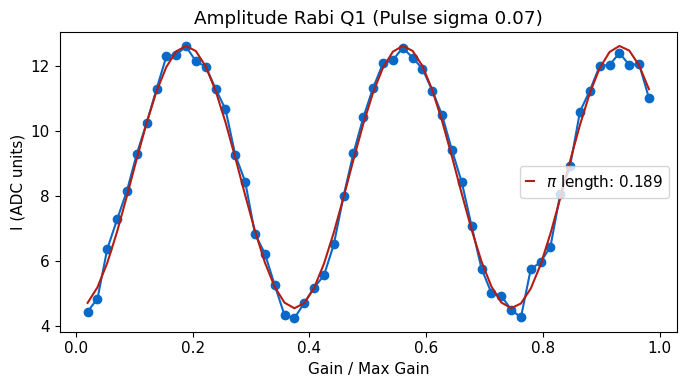

*Set cfg device.qubit 1 ('pulses', 'pi_ge', 'gain') to 0.1888 from 0.1867*


In [91]:
qubit_list = np.arange(13,20)
qubit_list=[1]

update=True

for qi in qubit_list: 
    #amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi)
    
    # Fully customized version
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'num_osc':5})

    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ge','gain'), amp_rabi.data['pi_length'], qi)
        

#### Chevron

Unexpected parameters found in params: {'expts_f', 'span_f'}


  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


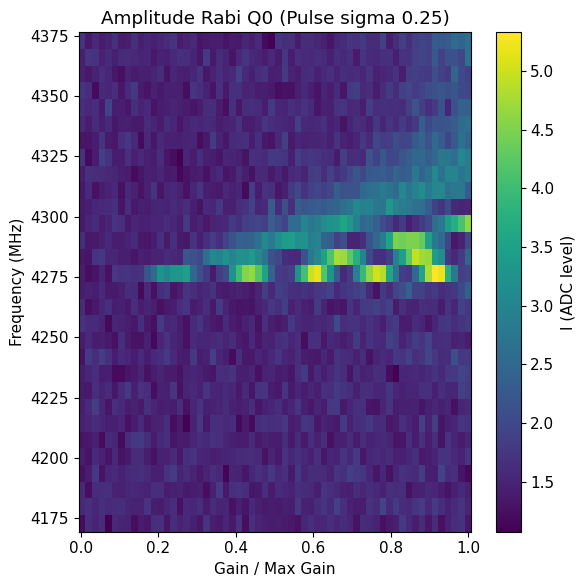

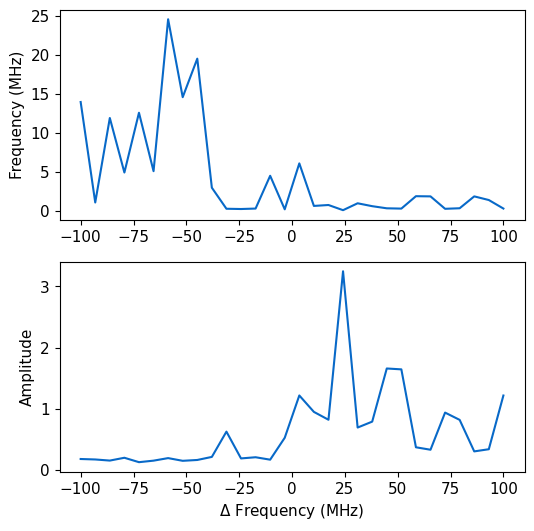

In [ ]:
d2=[]
qubit_list = np.arange(18)
# Fix ; doing length rabi by default, plotting error 
qubit_list=[0]
for qi in qubit_list: 
    amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'span_f':200,'sigma':0.25,'expts_f':100,'expts':100})

    #amp_rabi_chevron = meas.RabiChevronExperiment(cfg_dict,qi=qi)
    d2.append(amp_rabi)

#handy.plot_many(d2, title='Rabi Chevron Phase', save_path=cfg_dict['expt_path'], chan='phases')

#### 2 Qubit Rabi

In [ ]:
qi=[0,10]
amp_rabi = meas.Rabi_2Q(cfg_dict,qi=qi, params={'active_reset':False})

### Length -- Uses const pulses so do not use to set up pi pulses

In [ ]:
qubit_list = [1]
# This does not work with gaussian pulses due to multiplying qickparams issues -- need to fix
for qi in qubit_list: 
    # Needs to have params of sweep: length and type: const
    len_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'sweep':'length', 'type':'const'})

#### Chevron

In [ ]:
qubit_list = np.arange(20)
qubit_list=[2]
for qi in qubit_list: 
    len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.605, 'span_f':20})
    #len_rabi = meas.RabiChevronExperiment(cfg_dict,qi=qi, params={'sweep':'length',"type":"const", 'sigma':0.205, 'expts_f':60, 'span_f':150, 'gain':0.4,'start_f':6280,'soft_avgs':4})

## Ramsey

In [ ]:
qubit_list=[0]
update = True
for qi in qubit_list:
    #t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10)

    # Manually configured
    t2r = meas.T2Experiment(cfg_dict, qi=qi, max_err=10, params = {'ramsey_freq':0.2,'expts':100, 'span':35,'start':0.01})
    if t2r.status and update:
        config.update_qubit(cfg_path, 'f_ge', t2r.data['new_freq'], qi)
        auto_cfg = config.update_qubit(cfg_path, 'T2r', t2r.data['best_fit'][3], qi, rng_vals=[1.5, max_t1], sig=2)
    else:
        print('T2 Ramsey fit failed')

### Use Ramsey to recenter

In [ ]:
qubit_list = [2]
for qi in qubit_list:
    status = qubit_tuning.recenter(qi,cfg_dict)            

### Ramsey coherence

In [ ]:
t1= qubit_tuning.get_coherence(meas.RamseyExperiment, qi, cfg_dict,par='T2r')

## T1

  0%|          | 0/30720 [00:00<?, ?it/s]

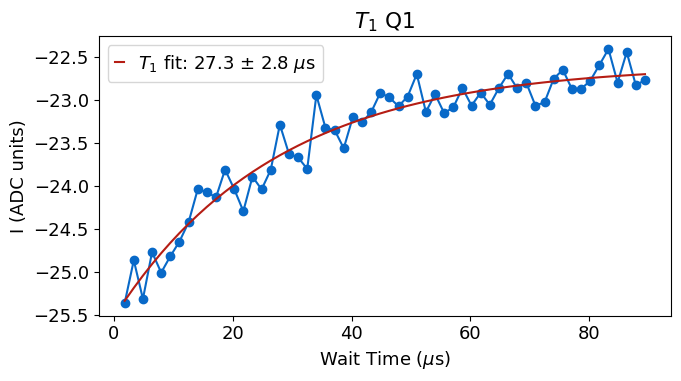

*Set cfg device.qubit 1 T1 to 27.26 from 24.53*
*Set cfg device.readout 1 final_delay to 163.54 from 147.18*


In [12]:
# If it's the first time, also set T2r and T2e as guesses 
update=True
first_time=False

qubit_list = np.arange(11,20)
qubit_list=[1]
for qi in qubit_list:
    t1 = meas.T1Experiment(cfg_dict, qi=qi)
    if update: t1.update(cfg_path, first_time=first_time)

### T1 coherence

Runs scan until scan is properly configured to be sensitive to T1

In [ ]:
qi=0
qubit_tuning.get_coherence(meas.T1Experiment,qi=qi,cfg_dict=cfg_dict,par='T1')

### Continuous scan at single point

In [ ]:
qi=0
meas.T1ContExperiment(cfg_dict,qi=qi, params={'shots':40000})

### T1 continuous 2Q

In [ ]:
qi = [10,0]
meas.T1_2Q(cfg_dict,qi=qi, )

In [ ]:
qi=[0,10]
scan_time = 0.1 #hours
number_of_scans = 1
shots = int(100000*scan_time*60/4)
print(shots)
for i in range(number_of_scans):
    meas.T1Cont2QExperiment(cfg_dict,qi=qi, params={'shots':shots, 'active_reset':False})


## Echo

In [ ]:
qubit_list = np.arange(20)
qubit_list=[1]
update=True
for qi in qubit_list:
    # Need to have experiiment type set to echo
    t2e = meas.T2Experiment(cfg_dict, qi=qi, params={'experiment_type':'echo'})
    if t2e.status and update:
        auto_cfg = config.update_qubit(cfg_path, 'T2e', t2e.data['best_fit'][3], qi,sig=2, rng_vals=[1.5, max_t1*2])

### Get echo coherence

In [ ]:
qi=6
t2e = qubit_tuning.get_coherence(meas.RamseyEchoExperiment, qi, cfg_dict,'T2e')

## Feedback checks

In [ ]:
qi=10
reset = meas.MemoryExperiment(cfg_dict, qi=qi, params={'shots':1, 'expts':200})

In [ ]:
# Don't do the active reset, just do the repeated measurement 
qi=1
shot = meas.RepMeasExperiment(cfg_dict, qi=qi, params={'shots':30000,'active_reset':True, 'setup_reset':True})
shot.check_reset()

# Single Shot

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

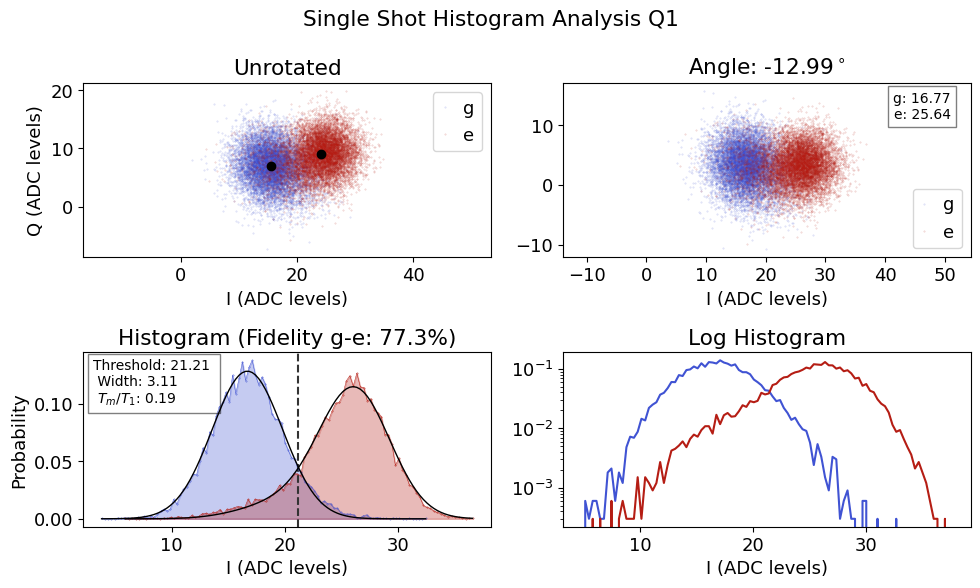

*Set cfg device.readout 1 phase to -12.9916 from 15.6293*
*Set cfg device.readout 1 threshold to 21.2082 from 10.8941*
*Set cfg device.readout 1 fidelity to 0.7726 from 0.5882*
*Set cfg device.readout 1 sigma to 3.1128 from 3.8238*
*Set cfg device.readout 1 tm to 0.192 from 0.1118*
*Set cfg device.qubit 1 tuned_up to True from True*


In [33]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[1]

for qi in qubit_list:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi)

    # Configure number of shots
    #shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':300000})
    shot.update(cfg_path)
    

## Readout opt

### General sweep

Runs single shot experiments for many readout lengths, frequencies, gains and compares fidelity

Unexpected parameters found in params: {'step_gain', 'step_f', 'step_len'}


  0%|          | 0/7 [00:00<?, ?it/s]

Max fidelity 77.588 %
Optimal params: 
 Freq (MHz) 1398.631 
 Gain (DAC units) 0.972 
 Readout length (us) 6.297
Set fidelity: 73.739 %
Set params: 
 Freq (MHz) 1398.631 
 Gain (DAC units) 0.833 
 Readout length (us) 4.948


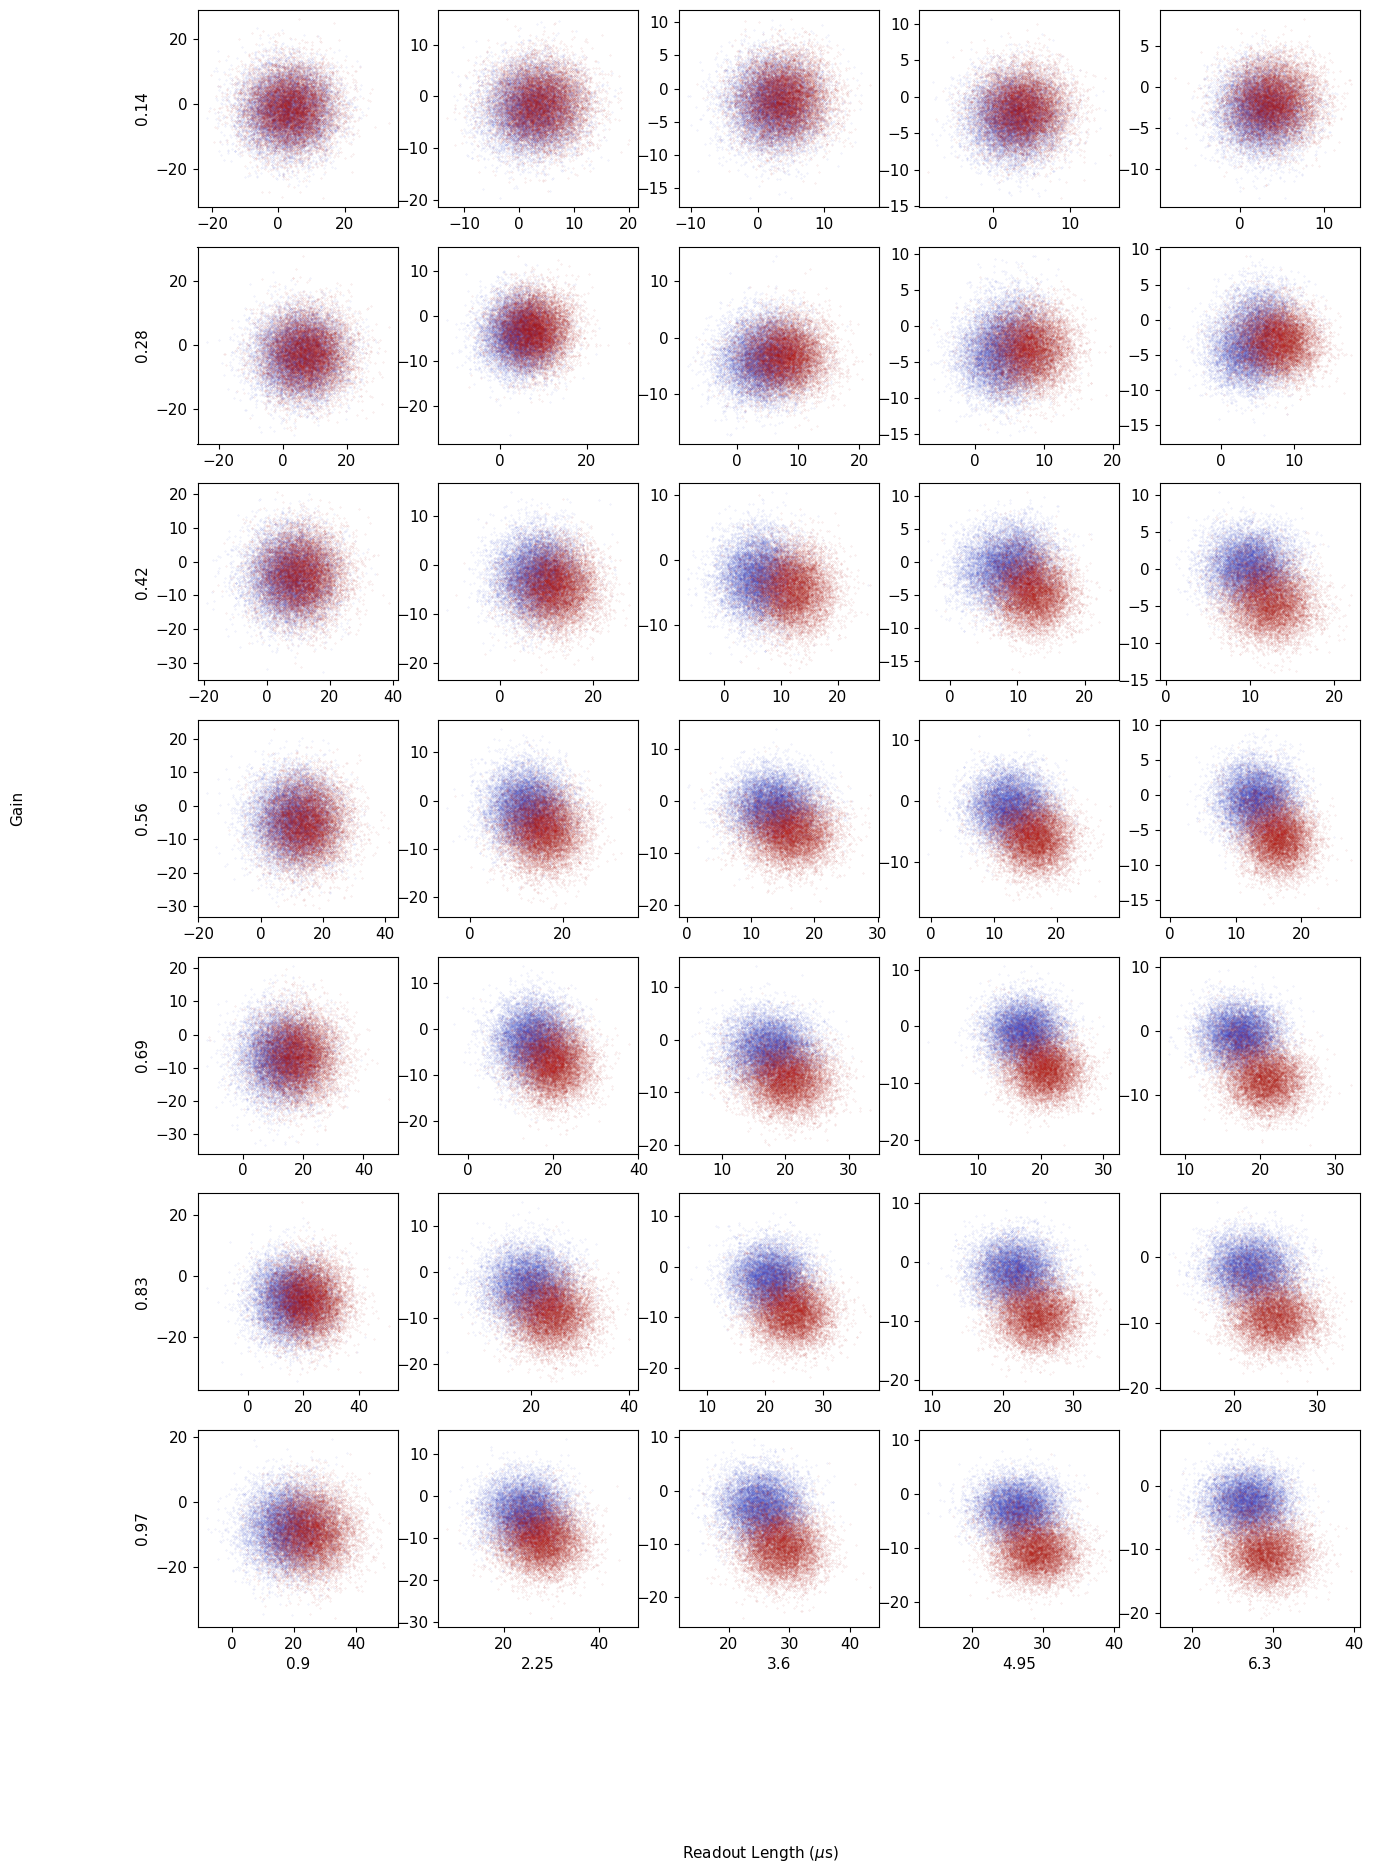

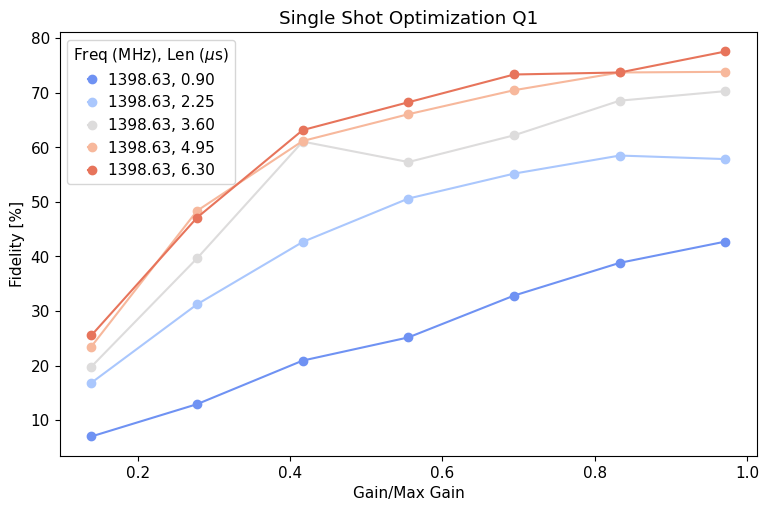

Fidelity is not maximized at the center of the sweep.
Max fidelity found at indices: (0, 6, 4)
Max fidelity 77.588 %
Optimal params: 
 Freq (MHz) 1398.631 
 Gain (DAC units) 0.972 
 Readout length (us) 6.297
Set fidelity: 73.739 %
Set params: 
 Freq (MHz) 1398.631 
 Gain (DAC units) 0.833 
 Readout length (us) 4.948
*Set cfg device.readout 1 gain to 0.8329 from 0.4627*
*Set cfg device.readout 1 readout_length to 4.948 from 2.9988*
*Set cfg device.readout 1 frequency to 1398.6308 from 1398.6308*


In [7]:

update=True
# Chooses lowest gain/readout length within a few percent of maximum gain (often readout fidelity fairly flat as a function of gain at higher gain values) 
low_gain=True

qubit_list=np.arange(14,20)
qubit_list=[1]

params = {'expts_f':1, 'expts_gain':7, 'expts_len':5}
#params = {'expts_f':10, 'expts_gain':1, 'expts_len':1}

# Specify exact ranges to use  
#params = {'expts_f':1, 'expts_gain':9, 'expts_len':9,'start_gain':0.45, 'span_gain':0.05,'start_len':2, 'span_len':5}

for qi in qubit_list: 
    # style='fine' varies parameters by 20%, style='' varies by 2x
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params=params)#, style='fine')
    shotopt.analyze(low_gain=low_gain)
    if update: shotopt.update(cfg_dict['cfg_file'])

### Run optimization until it converges

In [ ]:
qubit_list=np.arange(20)
qubit_list=[19]
params = {'expts_f':1, 'expts_gain':7, 'expts_len':7}

# do_res also runs res spec and resets readout frequency that way each round. 
qubit_tuning.meas_opt(cfg_dict, qubit_list, params, do_res=True)

### Vary trig_offset to see if it changes fidelity. 

In [ ]:
# Single shot 
qubit_list = np.arange(13,20)
qubit_list =[11]
trig_list = np.linspace(0.2,1,12)
fids =[]
for qi in qubit_list:
    for trig in trig_list: 
        config.update_readout(cfg_path, 'trig_offset', trig, qi);
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000, 'trigger':trig})
        fids.append(shot.data['fids'][0])
    

### Play with LO freq (when using qick for LO)

In [ ]:
auto_cfg = config.load(cfg_path)
start_freq = auto_cfg.device.readout.frequency[qi]
start_mixer = auto_cfg.hw.soc.lo.mixer_freq[qi]
rng = np.linspace(-1000,1000,11)
fids=[]
for qi in qubit_list: 
    for r in rng: 
        config.update_lo(cfg_path, 'mixer_freq', start_mixer+r, qi)
        config.update_readout(cfg_path, 'frequency', start_freq-r, qi)
        shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        fids.append(shot.data['fids'][0])

config.update_lo(cfg_path, 'mixer_freq', start_mixer, qi)
config.update_readout(cfg_path, 'frequency', start_freq, qi)

#### Play with LO power

In [ ]:
qi = 11
gain_vals = [0.0375,0.05] 
fids = []
for gain in gain_vals:
    config.update_lo(cfg_path, 'gain', gain, qi)
    shotopt=meas.SingleShotOptExperiment(cfg_dict, qi=qi,params={'npts_f':5, 'npts_gain':5, 'npts_len':5})
    fids.append(shot.data['fids'][0])

### Adjust reps for fidelity 

In [16]:
max_inc = 15 # dont' let it do more than 15x standard number of reps so that things don't take forever
qubit_list = [1,2,3,4,5]

auto_cfg = config.load(cfg_path)
for qi in qubit_list:
    config.update_readout(cfg_path, 'reps', 1/auto_cfg['device']['readout']['fidelity'][qi]**1.5, qi, rng_vals=[1,max_inc]);

*Set cfg device.readout 1 reps to 3.0354 from 1.2814*
*Set cfg device.readout 2 reps to 1.3809 from 1.5781*
*Set cfg device.readout 3 reps to 1.9744 from 2.1315*
*Set cfg device.readout 4 reps to 1.5693 from 1.8724*
*Set cfg device.readout 5 reps to 1.9965 from 1.9965*


## Active reset

### Check active reset at standard threshold

In [ ]:
# Setup reset uses the calibrated angle and runs active reset process at end, but also uses usual final_delay so that it's ok if reset not working
qubit_list = np.arange(15,20)
qubit_list=[3]
d=[]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'active_reset':True, 'setup_reset':True})
    shot.check_reset()
    #config.update_readout(cfg_path, 'reset_e', shot.data['reset_e'], qi)
    #config.update_readout(cfg_path, 'reset_g', shot.data['reset_g'], qi)
    d.append(shot)

### Sweep threshold

In [ ]:
d = []
qi=10
auto_cfg = config.load(cfg_path)
threshold = auto_cfg['device']['readout']['threshold'][qi]
thresh = np.linspace(threshold-25,threshold+25,16)
#thresh = np.linspace(threshold-10,threshold+10,6)
for t in thresh:
    shot=meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':100000,'threshold_v':t, 'active_reset':True,'setup_reset':True}, display=False, progress=False)
    d.append(shot)
    #shot.check_reset()
tuneup.plot_reset(d)

### Turn off active reset for all config chans

In [ ]:
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',False, qi)

### Turn on active reset for channels where it seems to be working

In [ ]:
e_success = 0.15 # Ratio of e proportion after active reset compared to before
g_vs_e = 2 # Ratio of g proportion to e proportion after active reset

auto_cfg = config.load(cfg_path)
reset_e = auto_cfg['device']['readout']['reset_e']
reset_g = auto_cfg['device']['readout']['reset_g']
result = np.array(reset_e)< e_success | np.array(reset_g)/np.array(reset_e)<g_vs_e
for qi in range(20):
    config.update_readout(cfg_path, 'active_reset',bool(result[qi]), qi)

### Check reset (plotting result of reset)

In [ ]:
qubit_list = np.arange(11,20)
qubit_list =[17]
for qi in qubit_list:
    shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':50000,'active_reset':True})
    shot.check_reset()

# Chi

In [ ]:
# Need a tuned up pi pulse for this
#for i in range(num_qubits):
qubit_list = [0]
for qi in qubit_list: 
    chi, chi_val=tuneup.check_chi(cfg_dict, qi)
    auto_cfg = config.update_readout(cfg_path, 'chi', chi_val, qi)


# 2 Qubit

In [ ]:
t12q = meas.T1_2Q(cfg_dict, qi=[10,0], params={'active_reset':False, })

In [ ]:
rabi2q = meas.Rabi_2Q(cfg_dict, qi=[10,0], params={'active_reset':True})

# EF 

### Initial setting of frequencies based on guess for alpha

In [ ]:
# Initial set of the frequencyies based on guess for alpha 
alpha = -180
qubit_list = np.arange(20)
auto_cfg = config.load(cfg_path)
for i in qubit_list: 
    f_ge = auto_cfg['device']['qubit']['f_ge'][i]
    auto_cfg = config.update_qubit(cfg_path, 'f_ef', f_ge+alpha, i)

## Spectroscopy EF

### General search

Performing medium scan


  0%|          | 0/607000 [00:00<?, ?it/s]

R2:0.045	Fit par error:0.263	 Best fit:b'amps'


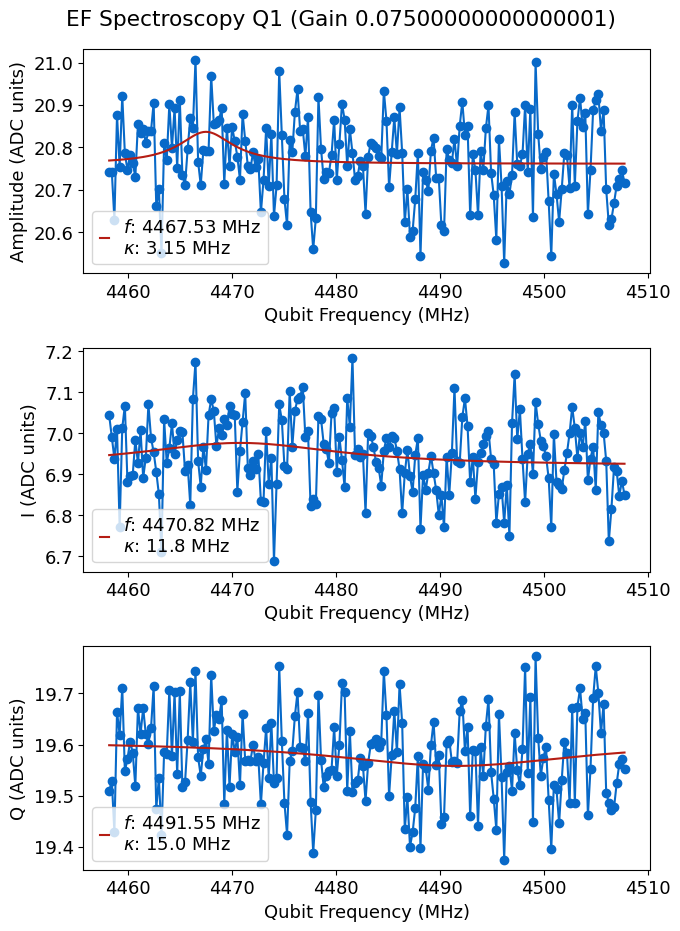

Performing coarse scan


  0%|          | 0/1517500 [00:00<?, ?it/s]

R2:0.636	Fit par error:0.029	 Best fit:b'avgi'


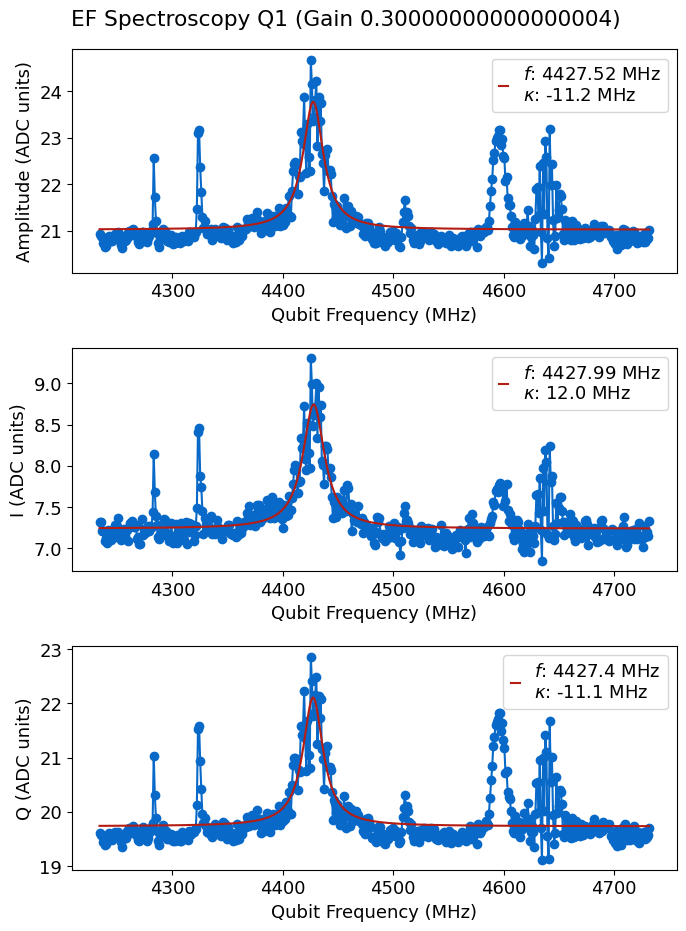

*Set cfg device.qubit 1 f_ef to 4427.9867 from 4482.9871*
Performing medium scan


  0%|          | 0/607000 [00:00<?, ?it/s]

R2:0.877	Fit par error:0.022	 Best fit:b'amps'


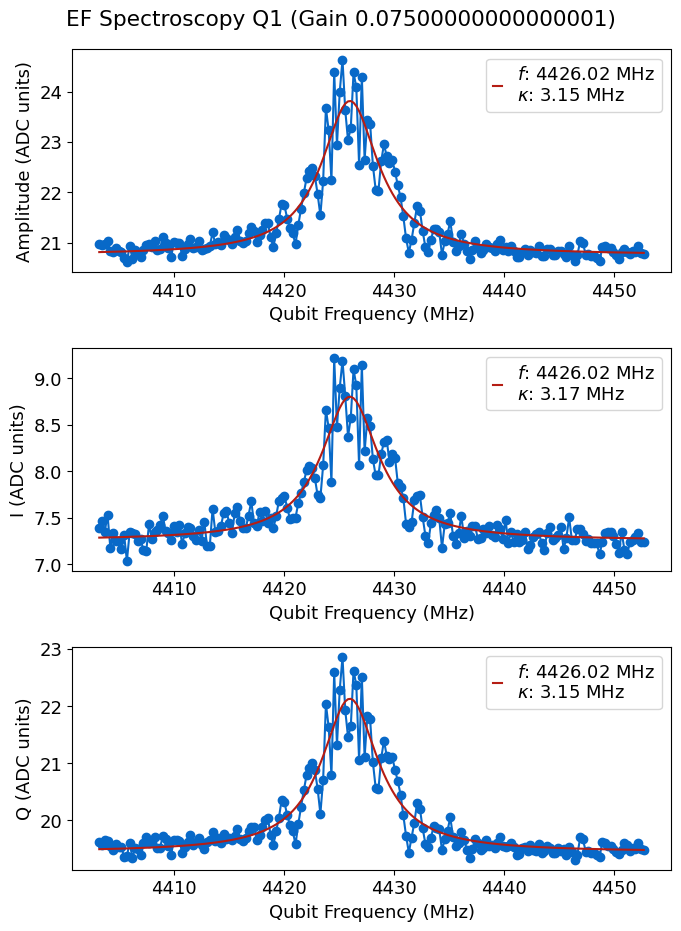

*Set cfg device.qubit 1 f_ef to 4426.0201 from 4427.9867*
Performing fine scan


  0%|          | 0/607000 [00:00<?, ?it/s]

R2:0.624	Fit par error:0.078	 Best fit:b'avgi'


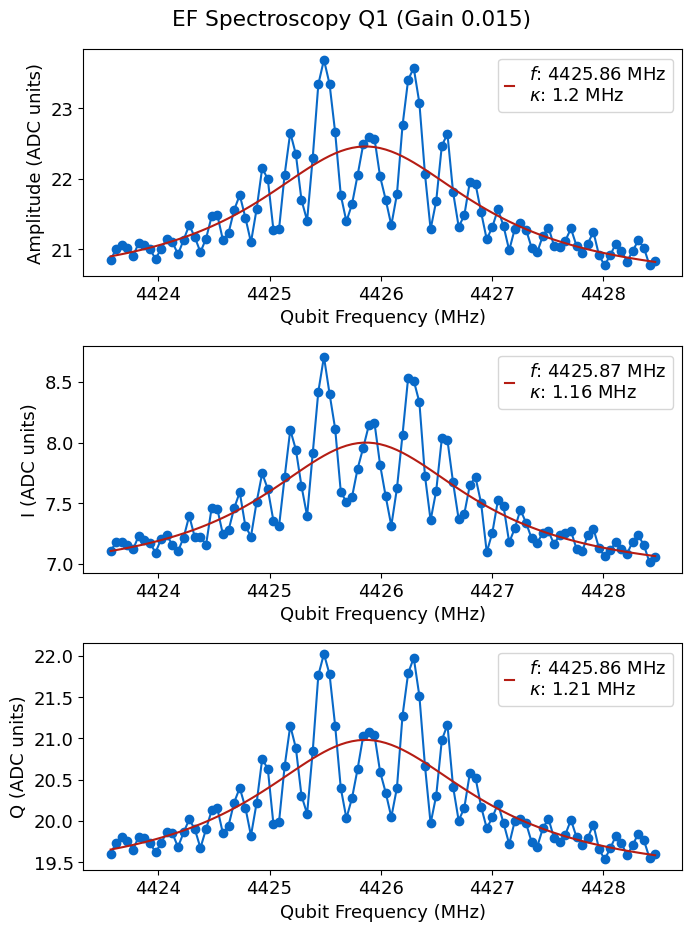

*Set cfg device.qubit 1 f_ef to 4425.8679 from 4426.0201*
Found qubit 1


In [65]:
qubit_list= np.arange(1,20)
bad_qubits=[]
qubit_list=[1]
for qi in qubit_list:
    status, ntries = qubit_tuning.find_spec(qi, cfg_dict, start='medium', freq='ef')
    if not status:
        bad_qubits.append(qi)

### Specific width

In [ ]:
# You may want to update this frequency, which will be the center of the scan. 
#style huge, coarse, medium, fine 
update=True

qubit_list = np.arange(10)
qubit_list=[2]
for qi in qubit_list:
    qspec=meas.QubitSpec(cfg_dict, qi=qi, style='coarse', params={'checkEF':True, 'gain':1,'reps':2000})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})

    #qspec=meas.QubitSpec(cfg_dict, qi=qi, style='medium', params={'checkEF':True})#, params={'span':500, 'expts':1000,'reps':500,'gain':0.2})
    if update and qspec.status:
        auto_cfg = config.update_qubit(cfg_path, 'f_ef', qspec.data["best_fit"][2], qi)

## Rabi EF

*Set cfg device.qubit 1 ('pulses', 'pi_ef', 'sigma') to 0.07 from 0.1*
*Set cfg device.qubit 1 ('pulses', 'pi_ef', 'gain') to 0.1862 from 0.0886*


  0%|          | 0/36420 [00:00<?, ?it/s]

R2:0.968	Fit par error:0.016	 Best fit:b'avgi'


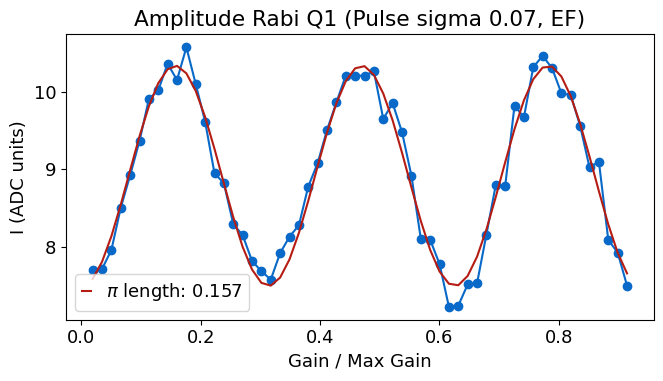

*Set cfg device.qubit 1 ('pulses', 'pi_ef', 'gain') to 0.1572 from 0.1862*


In [66]:
# If first time, initialize the sigma and gain to those of the ge 
first_time =True
update = True

qubit_list = np.arange(1,20)
qubit_list=[1]

bad_qubits = []
auto_cfg = config.load(cfg_path)

for qi in qubit_list: 
    if first_time:
        #config.update_qubit(cfg_path, 'f_ef', auto_cfg.device.qubit.f_spec_ef[qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','sigma'), auto_cfg['device']['qubit']['pulses']['pi_ge']['sigma'][qi], qi)
        auto_cfg = config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), auto_cfg['device']['qubit']['pulses']['pi_ge']['gain'][qi], qi)
    amp_rabi = meas.RabiExperiment(cfg_dict,qi=qi, params={'checkEF':True})
    if update and amp_rabi.status:
        config.update_qubit(cfg_path, ('pulses','pi_ef','gain'), amp_rabi.data['pi_length'], qi)
    else:
        print(f'Amplitude Rabi fit failed for qubit {qi}')
        bad_qubits.append(qi)

## Qubit Temperature

  0%|          | 0/36420 [00:00<?, ?it/s]

R2:0.694	Fit par error:0.055	 Best fit:b'avgi'


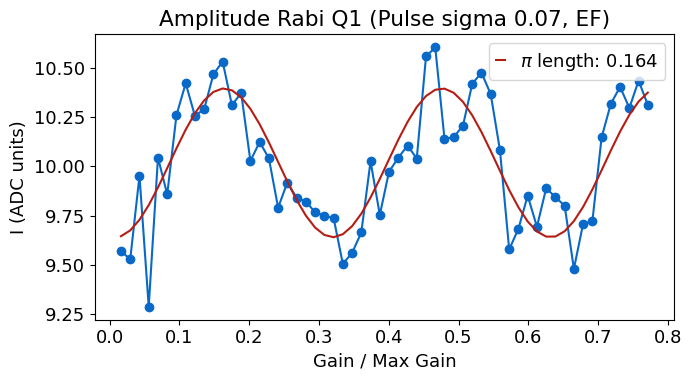

  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [67]:
qubit_list = np.arange(1)
qubit_list=[1]
for qi in qubit_list: 
    # Soft_avgs will make scan take longer, needed for lower temperatures. 
    temp, pop = tuneup.measure_temp(cfg_dict, qi=qi)# , soft_avgs=5)
    auto_cfg = config.update_qubit(cfg_path, 'temp', temp, qi)
    auto_cfg = config.update_qubit(cfg_path, 'pop', pop, qi)

## Ramsey EF

In [ ]:
update=True
qubit_list=np.arange(1,20)
qubit_list=[12]

for qi in qubit_list:
    t2r = meas.RamseyExperiment(cfg_dict, qi=qi, params={'ramsey_freq':0.1, 'checkEF':True})

    if update and t2r.status:
        config.update_qubit(cfg_path, 'f_ef', t2r.data['new_freq'], qi)
    else:
        print('T2 Ramsey fit failed')

# Stark

## Ramsey

### Single experiment

In [ ]:
qi=10
meas.RamseyStarkExperiment(cfg_dict, qi=qi, params={'stark_gain':0.0,'step':0.1,'df':200,'acStark':False,'ramsey_freq':0.1})

### Sweep frequency

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[3]
gain = np.linspace(0.1,1,10)
for qi in qubit_list:
    for g in gain:
        t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':g, 'start_df':30, 'end_df':150, 'expts_df':10})

In [ ]:
qubit_list = np.arange(3,20)
qubit_list=[17]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkFreqExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'stark_gain':0.1, 'start_df':20, 'end_df':100, 'expts_df':40})

### Calibrate stark power positive freq

In [ ]:
qubit_list = np.arange(13,20)
qubit_list=[19]
d=[]
freqs= [200]
for f in freqs:
    for qi in qubit_list:
        t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':f, 'start_gain':0.1, 'end_gain':1})
        d.append(t2rstark)
        config.update_stark(cfg_path, 'q', t2rstark.data['quad_fit'][0], qi)
        config.update_stark(cfg_path, 'l', t2rstark.data['quad_fit'][1], qi)
        config.update_stark(cfg_path, 'o', t2rstark.data['quad_fit'][2], qi)

In [ ]:
plt.figure()
for i in range(len(t2rstark.data['bin_centers'])):
    plt.plot(t2rstark.data['bin_centers'][i], t2rstark.data['hist'][i])

### Negative frequency

In [ ]:
#qubit_list = np.arange(20)
d=[]
qubit_list=[19]
for qi in qubit_list:
    t2rstark=meas.RamseyStarkPowerExperiment(cfg_dict, qi=qi, params={'step':1/430+0.001, 'expts_gain':12, 'df':-100, 'start_gain':0.08, 'end_gain':0.35, 'soft_avgs':2})
    d.append(t2rstark)
    config.update_stark(cfg_path, 'qneg', t2rstark.data['quad_fit'][0], qi)
    config.update_stark(cfg_path, 'lneg', t2rstark.data['quad_fit'][1], qi)
    config.update_stark(cfg_path, 'oneg', t2rstark.data['quad_fit'][2], qi)
#handy.plot_many(d, title='Ramsey Stark', save_path=cfg_dict['expt_path'])

## T1

### Single exp

In [ ]:
qi=19
gain_list = [0.5,0.6,0.77]
for g in gain_list:
    t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':g,'expts':300,'span':10}) 

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':10}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':10}) 
t1x = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':5}) 
t1y = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7,'end_wait':5}) 
t13 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2,'end_wait':0.05}) 
t14 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7, 'end_wait':0.05}) 

plt.plot(t1.data['bin_centers'], t1.data['hist'], 'r')
plt.plot(t12.data['bin_centers'], t12.data['hist'],'r')

plt.plot(t1x.data['bin_centers'], t12.data['hist'],'g')
plt.plot(t1y.data['bin_centers'], t12.data['hist'],'g')

plt.plot(t13.data['bin_centers'], t13.data['hist'],'b')
plt.plot(t14.data['bin_centers'], t14.data['hist'],'b')

In [ ]:
plt.figure()

t1 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.2}) 
t12 = meas.T1StarkExperiment(cfg_dict, qi=qi, params={'active_reset':False, 'df':200, 'stark_gain':0.7}) 
plt.plot(t1.data['bin_centers'], t1.data['hist'])
plt.plot(t12.data['bin_centers'], t12.data['hist'])

### Gain sweep

In [ ]:
qubit_list = np.arange(12,20)
qubit_list=[19]
flist=[210,180]
for f in flist:
    for qi in qubit_list: 
        #t1_neg = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':-70,'start_gain':0.02,'end_gain':0.2,'start':3, 'soft_avgs':4})

        t1_pos = meas.T1StarkPowerExperiment(cfg_dict, qi=qi, params={'df':f,'start_gain':0.3,'end_gain':1,'start':0.2, 'soft_avgs':1,'span':0.5,'expts_gain':80}) #, 'start':100,'span':0.34, 'expts':100, 'soft_avgs':3})
        plt.figure()
        for i in range(len(t1_pos.data['bin_centers'])):
            plt.plot(t1_pos.data['bin_centers'][i], t1_pos.data['hist'][i])

### Freq sweep

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100})

In [ ]:
t1_freq = meas.T1StarkFreqExperiment(cfg_dict, qi=19, params={'span':6, 'span_f':100, 'start_df':50, 'expts_f':100,'gain':0.5})

### Single evo point linear gain sweep

In [ ]:
t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=0, params={"soft_avgs":4})

### Run linear scan for multiple qubits

In [ ]:
#first, need to configure active reset and check stark for all. 
nexp = 3
qubit_list =[1,2]#2,4,5,6,7]
expts = 200
t1_data = [[] for _ in qubit_list]

for i in range(nexp):
    for j, qi in enumerate(qubit_list):
        t1_cont = meas.T1StarkPowerSingle(cfg_dict, qi=qi, params={ "soft_avgs":2,'expts':100})
        t1_data[j].append(t1_cont.data['t1'])

plt.figure()
fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()
for i, qi in enumerate(qubit_list):
    ax[i].set_title(f'Q{qi}')
    ax[i].pcolormesh(t1_data[i])
    plt.colorbar(ax[i].collections[0], ax=ax[i])

### Repeated single evo, sweep frequency linearly with gain [Main scan]

In [ ]:
d=[]
qi=6
params={'stop_f':20, 'df_pos':100, 'df_neg':-70}
for i in range(200):
    if i%10==0:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params)
        shot = meas.HistogramExperiment(cfg_dict, qi=qi, params={'shots':20000})
        config.update_readout(cfg_path, 'threshold',shot.data['thresholds'][0], qi);
        config.update_readout(cfg_path, 'phase', shot.data['angle'], qi);
        phase.append(shot.data['angle'])
    else:
        t1stark=meas.T1StarkPowerQuadSingle(cfg_dict, qi=qi, params=params, display=False, progress=False)

    d.append(t1stark)

times = [d[i].data['start_time'] for i in range(0, len(d))] 
tm = [datetime.strptime(times[i].decode('utf-8'), '%Y-%m-%d %H:%M:%S') for i in range(len(times))]
time_from_first = [(t - tm[0]).total_seconds() for t in tm]
print(time_from_first)

concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)

plt.figure()
plt.pcolormesh(concatenated_data)

In [ ]:
plt.figure()
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(0, len(d))], axis=1)
import matplotlib.dates as mdates

plt.pcolormesh(np.array(time_from_first)/60/60, d[-1].data['f_pts'], concatenated_data)
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
#plt.gcf().autofmt_xdate()


### Calib sweep

### Analysis of multiple evo times using normal fittingh

In [ ]:
# Processing for multiple evo times 
cd0 = np.concatenate([d[i].data['avgi_0'] for i in range(0, len(d))], axis=1)
cd1 = np.concatenate([d[i].data['avgi_1'] for i in range(0, len(d))], axis=1)
cd2 = np.concatenate([d[i].data['avgi_2'] for i in range(0, len(d))], axis=1)
cd3 = np.concatenate([d[i].data['avgi_3'] for i in range(0, len(d))], axis=1)

combined_cd = np.stack((cd0, cd1, cd2, cd3), axis=-1)
print(combined_cd.shape)

tms=d[0].data['wait_times']

sns.set_palette('coolwarm',len(combined_cd))
from scipy.optimize import curve_fit
plt.figure()
def t1_fit(x, a, b, c):
    return b * np.exp(-x / c) + a
fits=[]
tm_full = np.linspace(0, tms[3])
#for i in range(5):
for i in range(len(combined_cd)):
    plt.plot(tms, combined_cd[i][0][:],'o-')
    p0 = (np.min(combined_cd[i][0][:]), np.max(combined_cd[i][0][:])-np.min(combined_cd[i][0][:]), tms[2])
    popt, err = curve_fit(t1_fit, tms, combined_cd[i][0][:], p0=p0)
    fit_err = np.sqrt(np.diag(err))   
    if np.mean(fit_err/np.abs(popt))>0.5:
        fits.append(np.nan*np.ones(3))   
    else:
        fits.append(popt)
    #print(p0)
    #plt.plot(tm_full, t1_fit(np.array(tm_full), *popt),'k', label=f'Fit {i}')
    #print(popt)
#plt.legend()
t1_data = [fits[i][2] for i in range(len(fits))]    
offset = [fits[i][0] for i in range(len(fits))]
amp = [fits[i][1] for i in range(len(fits))]

fig, ax = plt.subplots(3, 1, figsize=(8, 7))
ax[0].plot(t1_data, 'o-')
ax[1].plot(offset, 'o-')
ax[2].plot(amp, 'o-')

In [ ]:
# Concatenate all d[i].data['avgi'] into a single dataset
concatenated_data = np.concatenate([d[i].data['avgi'] for i in range(1, len(d))], axis=1)

#print(concatenated_data)

plt.figure()
plt.pcolormesh(concatenated_data)

#### Check max value for calibration

In [ ]:
np.max(t1.data['avgi'], axis=1)
plt.figure()
plt.plot(np.max(t1.data['avgi'], axis=1))